## Chapter 7 - Part 3: Distributed tuning on Apache Spark for Aircraft Passenger forecasting
##### Author: Ben Wilson
<br>
To begin with, in this section, we will be looking at how to transform our forecasting problem from a single stand-alone VM problem that is synchronous in nature in to something that leverages a distributed approach to reduce the total runtime of the tuning and inference of the ExponentialSmoothing models we've been building.
In the last series of notebooks, we had come up with an end-to-end implementation for forecasting, utilizing hyperopt to tune our models through a specified search space. <br>
Here, we're going to import much of our original code, modifying it only slightly, in the effort to make this more scalable.

#### A note on the platform...
Since we're using Apache Spark to scale this problem out, we're going to be using the platform that was built by the very people who invented Spark: Databricks. 
There are a number of reasons to do this (which will become quite clear as we move through this implementation), but at a cursory overview position for the reasons:
1. The platform is managed. We don't have to setup Spark, configure it for ML purposes, or deal with any administrative tasks associated with the system.
2. There's a runtime for Spark that already has <i>most of the packages</i> that we need for most tasks that we're going to be doing with 'traditional Data Science work' ready-made for us.
3. It has an instance of hosted MLFlow running on it, which will make our tuning tracking far simpler (and we won't have to make any more crazy matplotlib visualizations to see how the optimization occurred!)

As before in the standalone Python Jupyter notebooks that we were running, we need to get our import statements somewhere near the very top as a standard habit.

In [0]:
%conda update -n base -c defaults conda

Python interpreter will be restarted.
Collecting package metadata (current_repodata.json): ...working... done
Solving environment: ...working... done

## Package Plan ##

 environment location: /databricks/conda

 added / updated specs:
 - conda


The following packages will be downloaded:

 package | build
 ---------------------------|-----------------
 brotlipy-0.7.0 |py37h27cfd23_1003 320 KB
 ca-certificates-2020.10.14 | 0 121 KB
 certifi-2020.11.8 | py37h06a4308_0 148 KB
 cffi-1.14.4 | py37h261ae71_0 224 KB
 chardet-3.0.4 |py37h06a4308_1003 175 KB
 conda-4.9.2 | py37h06a4308_0 2.9 MB
 conda-package-handling-1.7.2| py37h03888b9_0 885 KB
 cryptography-3.2.1 | py37h3c74f83_1 572 KB
 idna-2.10 | py_0 50 KB
 libedit-3.1.20191231 | h14c3975_1 116 KB
 libffi-3.3 | he6710b0_2 50 KB
 openssl-1.1.1h | h7b6447c_0 2.5 MB
 pycosat-0.6.3 | py37h27cfd23_0 81 KB
 pycparser-2.20 | py_2 94 KB
 pyopenssl-20.0.0 | pyhd3eb1b0_1 49 KB
 requests-2.25.0 | pyhd3eb1b0_0 52 KB
 ruamel_yaml-0.15.87 | py37h7b6447c_1 245 KB
 setuptools-50.3.2 | py37h06a4308_2 723 KB
 six-1.15.0 | py37h06a4308_0 27 KB
 sqlite-3.33.0 | h62c20be_0 1.1 MB
 tk-8.6.10 | hbc83047_0 3.0 MB
 tqdm-4.51.0 | pyhd3eb1b0_0 66 KB
 urllib3-1.25.11 | py_0 99 KB
 xz-5.2.5 | h7b6447c_0 341 KB
 yaml-0.2.5 | h7b6447c_0 75 KB
 ------------------------------------------------------------
 Total: 13.9 MB

The following NEW packages will be INSTALLED:

 brotlipy pkgs/main/linux-64::brotlipy-0.7.0-py37h27cfd23_1003

The following packages will be REMOVED:

 asn1crypto-1.3.0-py37_0
 pip-20.0.2-py37_1
 wheel-0.34.2-py37_0

The following packages will be UPDATED:

 ca-certificates 2020.1.1-0 --> 2020.10.14-0
 certifi 2019.11.28-py37_0 --> 2020.11.8-py37h06a4308_0
 cffi 1.14.0-py37h2e261b9_0 --> 1.14.4-py37h261ae71_0
 conda 4.8.2-py37_0 --> 4.9.2-py37h06a4308_0
 conda-package-han~ 1.6.0-py37h7b6447c_0 --> 1.7.2-py37h03888b9_0
 cryptography 2.8-py37h1ba5d50_0 --> 3.2.1-py37h3c74f83_1
 idna pkgs/main/linux-64::idna-2.8-py37_0 --> pkgs/main/noarch::idna-2.10-py_0
 libedit 3.1.20181209-hc058e9b_0 --> 3.1.20191231-h14c3975_1
 libffi 3.2.1-hd88cf55_4 --> 3.3-he6710b0_2
 ncurses 6.2-he6710b0_0 --> 6.2-he6710b0_1
 openssl 1.1.1d-h7b6447c_4 --> 1.1.1h-h7b6447c_0
 pycparser pkgs/main/linux-64::pycparser-2.19-py~ --> pkgs/main/noarch::pycparser-2.20-py_2
 pyopenssl pkgs/main/linux-64::pyopenssl-19.1.0-~ --> pkgs/main/noarch::pyopenssl-20.0.0-pyhd3eb1b0_1
 pysocks 1.7.1-py37_0 --> 1.7.1-py37_1
 requests pkgs/main/linux-64::requests-2.22.0-p~ --> pkgs/main/noarch::requests-2.25.0-pyhd3eb1b0_0
 ruamel_yaml 0.15.87-py37h7b6447c_0 --> 0.15.87-py37h7b6447c_1
 setuptools 45.2.0-py37_0 --> 50.3.2-py37h06a4308_2
 six 1.14.0-py37_0 --> 1.15.0-py37h06a4308_0
 sqlite 3.31.1-h7b6447c_0 --> 3.33.0-h62c20be_0
 tk 8.6.8-hbc83047_0 --> 8.6.10-hbc83047_0
 tqdm 4.42.1-py_0 --> 4.51.0-pyhd3eb1b0_0
 urllib3 pkgs/main/linux-64::urllib3-1.25.8-py~ --> pkgs/main/noarch::urllib3-1.25.11-py_0
 xz 5.2.4-h14c3975_4 --> 5.2.5-h7b6447c_0
 yaml 0.1.7-had09818_2 --> 0.2.5-h7b6447c_0

The following packages will be DOWNGRADED:

 chardet 3.0.4-py37_1003 --> 3.0.4-py37h06a4308_1003
 pycosat 0.6.3-py37h7b6447c_0 --> 0.6.3-py37h27cfd23_0



Downloading and Extracting Packages

brotlipy-0.7.0 | 320 KB | | 0% 
brotlipy-0.7.0 | 320 KB | ########## | 100% 

tk-8.6.10 | 3.0 MB | | 0% 
tk-8.6.10 | 3.0 MB | ########## | 100% 

ca-certificates-2020 | 121 KB | | 0% 
ca-certificates-2020 | 121 KB | ########## | 100% 

pycosat-0.6.3 | 81 KB | | 0% 
pycosat-0.6.3 | 81 KB | ########## | 100% 

pyopenssl-20.0.0 | 49 KB | | 0% 
pyopenssl-20.0.0 | 49 KB | ########## | 100% 

six-1.15.0 | 27 KB | | 0% 
six-1.15.0 | 27 KB | ########## | 100% 

libedit-3.1.20191231 | 116 KB | | 0% 
libedit-3.1.20191231 | 116 KB | ########## | 100% 

requests-2.25.0 | 52 KB | | 0% 
requests-2.25.0 | 52 KB | ########## | 100% 

libffi-3.3 | 50 KB | | 0% 
libffi-3.3 | 50 KB | ########## | 100% 

urllib3-1.25.11 | 99 KB | | 0% 
urllib3-1.25.11 | 99 KB | ########## | 100% 

openssl-1.1

In order to support a few of the indexing features that we used in our standalone VM code, we need to ensure that we have pandas updated to version 1.0.5. <br>
Let's use the conda magic command to update the environment with pandas 1.0.5 and all required dependencies.

In [0]:
%conda install -c conda-forge pandas==1.0.5

Python interpreter will be restarted.
Collecting package metadata (current_repodata.json): ...working... done
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Collecting package metadata (repodata.json): ...working... done
Solving environment: ...working... done

## Package Plan ##

 environment location: /local_disk0/.ephemeral_nfs/envs/pythonEnv-4bce3990-730a-453b-bba4-e50eee0deb3c

 added / updated specs:
 - pandas==1.0.5


The following packages will be downloaded:

 package | build
 ---------------------------|-----------------
 ca-certificates-2020.11.8 | ha878542_0 145 KB conda-forge
 certifi-2020.11.8 | py37h89c1867_0 150 KB conda-forge
 openssl-1.1.1h | h516909a_0 2.1 MB conda-forge
 pandas-1.0.5 | py37h0da4684_0 10.1 MB conda-forge
 python_abi-3.7 | 1_cp37m 4 KB conda-forge
 ------------------------------------------------------------
 Total: 12.5 MB

The following NEW packages will be INSTALLED:

 python_abi conda-forge/linux-64::python_abi-3.7-1_cp37m

The following packages will be UPDATED:

 ca-certificates pkgs/main::ca-certificates-2020.7.22-0 --> conda-forge::ca-certificates-2020.11.8-ha878542_0
 certifi pkgs/main::certifi-2020.6.20-py37_0 --> conda-forge::certifi-2020.11.8-py37h89c1867_0
 openssl pkgs/main::openssl-1.1.1g-h7b6447c_0 --> conda-forge::openssl-1.1.1h-h516909a_0
 pandas pkgs/main::pandas-1.0.1-py37h0573a6f_0 --> conda-forge::pandas-1.0.5-py37h0da4684_0



Downloading and Extracting Packages

certifi-2020.11.8 | 150 KB | | 0% 
certifi-2020.11.8 | 150 KB | #######4 | 75% 
certifi-2020.11.8 | 150 KB | ########## | 100% 

ca-certificates-2020 | 145 KB | | 0% 
ca-certificates-2020 | 145 KB | ########## | 100% 

pandas-1.0.5 | 10.1 MB | | 0% 
pandas-1.0.5 | 10.1 MB | ###1 | 31% 
pandas-1.0.5 | 10.1 MB | ########## | 100% 
pandas-1.0.5 | 10.1 MB | ########## | 100% 

python_abi-3.7 | 4 KB | | 0% 
python_abi-3.7 | 4 KB | ########## | 100% 

openssl-1.1.1h | 2.1 MB | | 0% 
openssl-1.1.1h | 2.1 MB | ########## | 100% 
openssl-1.1.1h | 2.1 MB | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Python interpreter will be restarted.

Define our import statements<br>
<p>```NOTE: out of habit, I typically organize my import statements by their functionality to make updating / cleaning them up after building prototypes / making them legible for later reference much easier.```</p>
<p> The typical arrangement I use is:
  - System (environment)
  - Core imports (language features, core utilities, et al)
  - Data Manipulation Frameworks
  - Modeling 
  - Tuning 
  - Visualization
  - Tooling </p>
  <p>Keeping imports arranged in this way for more complex projects (where there may be many dozens of imports) can save a lot of time and prevent redundant imports during development.
  > I have labeled these groups below, but in practice, you should leave no spaces between or comments among your import statements.

In [0]:
# System imports
import os
from os import devnull
from contextlib import contextmanager, redirect_stdout, redirect_stderr
# Core (Python) functionality imports
import copy
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from math import sqrt
import uuid
from functools import partial
# Data Manipulation Frameworks imports
import pandas as pd
import numpy as np
from pyspark.sql.types import *
from pyspark.sql.functions import *
# Modeling imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
# Tuning imports
from hyperopt import fmin, hp, tpe, SparkTrials, space_eval, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
# Visualization imports
import matplotlib.pylab as plt
from matplotlib import gridspec as gs
# Tooling imports
import mlflow

To begin with, we need to get our data into the platform. Since the data is in a repository on Github, we can use a driver-based shell command to curl download the file to the driver's hard drive temporarily.
> Since the cluster is ephemeral (once we shut it down, the files that we have downloaded will be gone forever), we will need to move this data from the driver's harddrive to permanent cloud object storage.

In [0]:
%sh curl -O 'https://raw.githubusercontent.com/alan-turing-institute/TCPD/master/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv' 

% Total % Received % Xferd Average Speed Time Time Time Current
 Dload Upload Total Spent Left Speed

 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
 0 0 0 0 0 0 0 0 --:--:-- --:--:-- --:--:-- 0
100 56665 100 56665 0 0 214k 0 --:--:-- --:--:-- --:--:-- 213k

Let's take a look at where that file was just downloaded to in order to make sure that we have the data.

In [0]:
%fs ls 'file:/databricks/driver/'

path name size file:/databricks/driver/conf/ conf/ 4096 file:/databricks/driver/derby.log derby.log 733 file:/databricks/driver/eventlogs/ eventlogs/ 4096 file:/databricks/driver/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv 56665 file:/databricks/driver/logs/ logs/ 4096

Now that we've made sure that the file is there, let's make sure that the data is what we're expecting it to be. Let's get the first 10 lines (let's not use a 'cat' command because this is a rather large number of lines to print out the entire file)
> <b>NOTE:</b> For an actual project, you don't need any of this visualization and validation of the data. It's going to work just fine. This is for <b><i>demonstration purposes only.</i></b>

In [0]:
%sh head --lines=10 '/databricks/driver/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'

Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers
ACY,2015,Jan,98177,90,98267
ACY,2015,Feb,96431,65,96496
ACY,2015,Mar,116493,197,116690
ACY,2015,Apr,105539,161,105700
ACY,2015,May,103668,425,104093
ACY,2015,Jun,96259,1102,97361
ACY,2015,Jul,109247,1894,111141
ACY,2015,Aug,108700,1932,110632
ACY,2015,Sep,82268,315,82583

And now that we know that the data is what we're expecting, let's go ahead and move the data from the driver location and to Object Store in the cloud. Once it's there, we're going to create a Delta DataFrame from it to make it much easier to read from, as well as much faster to acquire.

In [0]:
LOCAL_DATA_LOCATION = "file:/databricks/driver/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv"
RAW_DATA_LOCATION = "dbfs:/home/benjamin.wilson@databricks.com/demo/airports/nyc.csv"

In [0]:
# Move the .csv file from the driver's hard drive to the fuse mounted location on object store (otherwise the file will be lost to us forever when the cluster shuts down)
dbutils.fs.mv(LOCAL_DATA_LOCATION, RAW_DATA_LOCATION)

# Define the schema of the .csv file (since we're using Spark, which run in the JVM through a code base written in scala, we need to have strong typing to everything that we do - which is a good thing.)
airport_schema = StructType([
  StructField('Airport_Code', StringType()),
  StructField('Year', StringType()),
  StructField('Month', StringType()),
  StructField('Domestic_Passengers', IntegerType()),
  StructField('International_Passengers', IntegerType()),
  StructField('Total_Passengers', IntegerType())
])

# Define the locations and table names for the airport data for when we register the data set as a Delta table.
delta_save_location = '/home/benjamin.wilson@databricks.com/airport'
delta_table_nm = 'airport'
delta_database_nm = 'ben_demo'
delta_full_nm = "{}.{}".format(delta_database_nm, delta_table_nm)

# Read in the file from object store (from the location we put it) through Spark.
raw_data = spark.read.csv(RAW_DATA_LOCATION, header=True, inferSchema=False, schema=airport_schema).withColumn("day", lit("1"))
formatted_data = (raw_data
                  .withColumn("date_raw", concat_ws("-", *[col("year"), col("month"), col("day")]))
                  .withColumn("date", to_date(col("date_raw"), format='yyyy-MMM-d'))
                  .drop(*['Year', 'Month', 'day', 'date_raw'])
                 )

# Write the data into object store once more, but this time in Delta format (parquet-backed highly optimized cloud-based warehouse paradigm). We're using overwrite mode here to ensure a 'fresh copy' of this data in case this block is run multiple times.
formatted_data.write.format("delta").mode("overwrite").option("mergeSchema", "true").option("overwriteSchema", "true").partitionBy("Airport_Code").save(delta_save_location)

# Create (or use, if it already exists) a database, register the delta table as a Spark Table (in the Hive metastore), and compact the part files with an optimize command.
spark.sql("""CREATE DATABASE IF NOT EXISTS {};""".format(delta_database_nm))
spark.sql("""CREATE TABLE IF NOT EXISTS {} USING DELTA LOCATION '{}';""".format(delta_full_nm, delta_save_location))
# spark.sql("""OPTIMIZE {}""".format(delta_full_nm))

# We don't need the raw data anymore, so let's clean that up.
dbutils.fs.rm(RAW_DATA_LOCATION)

Out[5]: True

Now let's take a look at the table that we just created...

In [0]:
display(spark.table(delta_full_nm))

Airport_Code Domestic_Passengers International_Passengers Total_Passengers date JFK 1891156 2060967 3952123 2015-01-01 JFK 1806434 1718574 3525008 2015-02-01 JFK 2209055 2208031 4417086 2015-03-01 JFK 2252631 2381501 4634132 2015-04-01 JFK 2359873 2605811 4965684 2015-05-01 JFK 2380699 2773121 5153820 2015-06-01 JFK 2530151 3117712 5647863 2015-07-01 JFK 2535971 3273753 5809724 2015-08-01 JFK 2134468 2647629 4782097 2015-09-01 JFK 2328298 2571768 4900066 2015-10-01 JFK 2137376 2204682 4342058 2015-11-01 JFK 2240741 2456752 4697493 2015-12-01 JFK 1733180 1999728 3732908 2014-01-01 JFK 1600197 1640381 3240578 2014-02-01 JFK 2050809 2083681 4134490 2014-03-01 JFK 2093860 2317134 4410994 2014-04-01 JFK 2194904 2493662 4688566 2014-05-01 JFK 2209709 2628862 4838571 2014-06-01 JFK 2344328 2888135 5232463 2014-07-01 JFK 2410907 3066280 5477187 2014-08-01 JFK 2094037 2446975 4541012 2014-09-01 JFK 2164407 2348874 4513281 2014-10-01 JFK 1968395 1991784 3960179 2014-11-01 JFK 2156699 2290822 4447521 2014-12-01 JFK 1837638 1889308 3726946 2013-01-01 JFK 1636127 1546573 3182700 2013-02-01 JFK 2081615 2085558 4167173 2013-03-01 JFK 1925830 2039148 3964978 2013-04-01 JFK 2059717 2263544 4323261 2013-05-01 JFK 2106371 2489940 4596311 2013-06-01 JFK 2241887 2726286 4968173 2013-07-01 JFK 2268278 2820169 5088447 2013-08-01 JFK 1904407 2306002 4210409 2013-09-01 JFK 1991650 2217538 4209188 2013-10-01 JFK 1813415 1904207 3717622 2013-11-01 JFK 2042240 2252910 4295150 2013-12-01 JFK 1775776 1746929 3522705 2012-01-01 JFK 1719169 1520808 3239977 2012-02-01 JFK 2151141 1903272 4054413 2012-03-01 JFK 2056205 2074905 4131110 2012-04-01 JFK 2069256 2127613 4196869 2012-05-01 JFK 2150154 2372295 4522449 2012-06-01 JFK 2279417 2630326 4909743 2012-07-01 JFK 2302256 2684475 4986731 2012-08-01 JFK 1935799 2199135 4134934 2012-09-01 JFK 1908691 1935361 3844052 2012-10-01 JFK 1901968 1836685 3738653 2012-11-01 JFK 1967251 2025289 3992540 2012-12-01 JFK 1693776 1702462 3396238 2011-01-01 JFK 1588173 1396263 2984436 2011-02-01 JFK 2054681 1799902 3854583 2011-03-01 JFK 1964274 2004774 3969048 2011-04-01 JFK 2091363 2091539 4182902 2011-05-01 JFK 2121592 2224340 4345932 2011-06-01 JFK 2301727 2522166 4823893 2011-07-01 JFK 2137664 2402236 4539900 2011-08-01 JFK 1951994 2080198 4032192 2011-09-01 JFK 1999591 1997183 3996774 2011-10-01 JFK 1950189 1746428 3696617 2011-11-01 JFK 1903489 1918593 3822082 2011-12-01 JFK 1715308 1630461 3345769 2010-01-01 JFK 1503016 1378458 2881474 2010-02-01 JFK 1929849 1736163 3666012 2010-03-01 JFK 1883394 1741319 3624713 2010-04-01 JFK 1931696 2001224 3932920 2010-05-01 JFK 2103377 2178694 4282071 2010-06-01 JFK 2230636 2456409 4687045 2010-07-01 JFK 2255111 2463475 4718586 2010-08-01 JFK 1915327 2017928 3933255 2010-09-01 JFK 2041014 1972179 4013193 2010-10-01 JFK 2022362 1723291 3745653 2010-11-01 JFK 1873187 1817008 3690195 2010-12-01 JFK 1768859 1594086 3362945 2009-01-01 JFK 1668416 1335194 3003610 2009-02-01 JFK 2036804 1617790 3654594 2009-03-01 JFK 2050726 1774888 3825614 2009-04-01 JFK 2108892 1799906 3908798 2009-05-01 JFK 2163606 1950310 4113916 2009-06-01 JFK 2341718 2252860 4594578 2009-07-01 JFK 2354053 2337290 4691343 2009-08-01 JFK 1861490 1902411 3763901 2009-09-01 JFK 1942384 1858685 3801069 2009-10-01 JFK 1812214 1625556 3437770 2009-11-01 JFK 1912071 1807733 3719804 2009-12-01 JFK 1901340 1688786 3590126 2008-01-01 JFK 1789300 1478928 3268228 2008-02-01 JFK 2199145 1869574 4068719 2008-03-01 JFK 2157392 1786495 3943887 2008-04-01 JFK 2194908 1969038 4163946 2008-05-01 JFK 2280630 2055406 4336036 2008-06-01 JFK 2455147 2314585 4769732 2008-07-01 JFK 2440754 2379731 4820485 2008-08-01 JFK 1884655 1842307 3726962 2008-09-01 JFK 1991425 1820051 3811476 2008-10-01 JFK 1894311 1607426 3501737 2008-11-01 JFK 2015061 1786721 3801782 2008-12-01 JFK 1934117 1554887 3489004 2007-01-01 JFK 1728976 1278281 3007257 2007-02-01 JFK 2246579 1668913 3915492 2007-03-01 JFK 2285032 1747415 4032447 2007-04-01 JFK 2307120 1792700 

Everything seems to be in order now. The next step is going to make anyone who is familiar with Spark cringe, but since our data is very small and we're going to be using distributed hyperopt (and not distributed modeling) to speed things up, our code from the last section is going to go mostly unchanged.<br>
<b>Why?!</b><br>
Well, we're going to be doing most of the processing on this cluster on the actual driver, but we'll be using the workers to distribute hyperopt tuning to each of those machines.

The dreaded .toPandas() operation...<br>
For the vast majority of use cases on Spark, you <i><u><b>really should not be doing this</b></u></i> as it defeats the purpose of using a cluster (since it brings all of the data to the driver). But for THIS use case (distributed tuning for a relatively small data set) it's the ideal use of this method.

In [0]:
local_data = spark.table(delta_full_nm).toPandas()
local_data

Airport_Code 
 Domestic_Passengers 
 International_Passengers 
 Total_Passengers 
 date 
 
 
 
 
 0 
 JFK 
 1891156 
 2060967 
 3952123 
 2015-01-01 
 
 
 1 
 JFK 
 1806434 
 1718574 
 3525008 
 2015-02-01 
 
 
 2 
 JFK 
 2209055 
 2208031 
 4417086 
 2015-03-01 
 
 
 3 
 JFK 
 2252631 
 2381501 
 4634132 
 2015-04-01 
 
 
 4 
 JFK 
 2359873 
 2605811 
 4965684 
 2015-05-01 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 1579 
 LGA 
 1369092 
 0 
 1369092 
 1977-08-01 
 
 
 1580 
 LGA 
 1268316 
 0 
 1268316 
 1977-09-01 
 
 
 1581 
 LGA 
 1346132 
 0 
 1346132 
 1977-10-01 
 
 
 1582 
 LGA 
 1323301 
 0 
 1323301 
 1977-11-01 
 
 
 1583 
 LGA 
 1293393 
 0 
 1293393 
 1977-12-01 
 
 
 
 1584 rows × 5 columns

And now we're back in Pandas land... this looks exactly as it would in Jupyter. We'll be modifying the code below to support this reference paradigm (instead of reading from a local hard drive disk)

In [0]:
AIRPORT_FIELD = 'Airport_Code'
SERIES_FREQ = 'MS'
TID_COL = 'TestID'
BIG_FONT = 22
MED_FONT = 16
SMALL_FONT = 14

This function, ported over from the standalone Jupyter notebook in notebook CH7_2, still applies to running this on Spark (at least for the first example we're going to be running). Due to the fact that some of the combinations of hyperparameters that hyperopt will be selecting, the underlying model will be unable to fit correctly, thus raising warnings from the modeling execution code. We'd like to keep stdout in this notebook (as well as the stdout and stderr on the workers) free from irrelevant warnings.

In [0]:
@contextmanager
def suppress_annoying_prints():
    """ A contextmanager decorated function that allows for 'muting' stdout and stderr while wrapped around 
            another function execution. Specifically used for allowing for hiding the verbosity of hyperopt's
            minimization function.
    """
    with open(devnull, 'w') as black_hole:
        with redirect_stdout(black_hole) as chatter, redirect_stderr(black_hole) as noisy_errors:
            yield (chatter, noisy_errors)

Notice, if you compare this to the notebook for section 7_2, we've omitted two functions here (getting data from source disk) because they're not applicable. We're getting the data from our collected Spark Dataframe here.

In [0]:
def apply_index_freq(data, freq):
    """ Function for applying the correct temporal frequency to the Index of the Pandas DataFrame
    :param data: a Pandas DataFrame that has a date or datetime index set
    :param freq: a timespan frequency string. See 
        https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        for more information on allowable frequency strings.
    """
    return data.asfreq(freq)

def get_raw_data(delta_full_name):
  raw = spark.table(delta_full_name).toPandas()
  raw2 = raw.copy(deep=True)
  raw2['date'] = pd.to_datetime(raw2['date'])
  raw2.set_index('date', inplace=True)
  raw2.index = pd.DatetimeIndex(raw2.index.values, freq=raw2.index.inferred_freq)
  asc = raw2.sort_index()
  return asc
  
def get_airport_data_from_df(full_file, freq, airport):
    """ Function for filtering out a single airport from the full file
    :param full_file: the read-in DataFrame of the airport .csv
    :param freq: the timespan frequency string for the index temporal component
    :param airport: the airport key code to filter upon
    """
    filtered = full_file[full_file[AIRPORT_FIELD] == airport]
    return apply_index_freq(filtered, freq)

def get_all_airports_from_df(full_file):
    """ Function for returning the unique list of airports contained within the data set.
    :param full_file: 
    """
    return sorted(full_file[AIRPORT_FIELD].unique())

def generate_splits_by_months(data, months):
    """ Function for creating the train and test splits for the models, filling in missing index sequences 
            with a forward fill first (conservative estimation), followed by a backfill if the beginning of the
            series starts with a (or many) NaN value(s).
    :param data: a Pandas DataFrame object with a monthly date index
    :param months: the number of months to utilize for validation through the test set row count.
    """
    train = data[:-months].fillna(method='ffill').fillna(method='bfill')
    test = data[-months:].fillna(method='ffill').fillna(method='bfill')
    return train, test

def validate_data_counts(data, split_count):
    """ A utility validation function that checks to make sure that we have enough data to train on.
            The return type of this is a boolean that is used to determine whether we should attempt to 
            model this airport or not (if we can't, we can fallback to a simpler methodology that, although
            likely less accurate, can be a placeholder until we have enough data to trust in the predictions
            that a statistical model will give).
    :param data: the full data set prior to splitting into test and train
    :param split_count: the cutoff count for test data to ensure that we have enough of a ratio for the 
        model's training to hit at least a ratio of 80% train to 20% test. 
    """
    return split_count / 0.2 < len(data) * 0.8

These are the same error metric calculations from before in the notebook CH7_2

In [0]:
def mape(y_true, y_pred):
    """ Function for calculating Mean Absolute Percentage Error (MAPE) for comparing different models 
    :param y_true: The test holdout validation data (actual data during the test period)
    :param t_pred: The forecast prediction over the same temporal period as the test holdout series.
    """
    drop_case = y_true != 0
    return (np.fabs(y_true - y_pred) / y_true)[drop_case].mean() * 100

def aic(n, mse, param_count):
    """ Function for Akaike's Information Criterion (aic)
    :param n: the length of the series that is under test (in terms of a Pandas DataFrame, it's your row 
            count of test)
    :param mse: the mean squared error calculation for the test vs. predicted data
    :param param_count: the number of hyperparameters under test for the algorithm being evaluated.
    """
    return n * np.log(mse) + 2 * param_count

def bic(n, mse, param_count):
    """ Function for Schwarz's Bayesian Information Criterion (bic)
    :param n: the length of the series that is under test (in terms of a Pandas DataFrame, it's your row 
            count of test)
    :param mse: the mean squared error calculation for the test vs. predicted data
    :param param_count: the number of hyperparameters under test for the algorithm being evaluated.
    """
    return n * np.log(mse) + param_count * np.log(n)

def calculate_errors(y_true, y_pred, param_count):
    """ Function for calculation of the errors that we want to record for each of the iterations of hyperparameter
            testing. 
            NOTE: the try/catch blocks in here are for handling the nigh inevitable loss errors that will 
            occur when trying certain combinations of parameters that will cause the predicted series to 
            either rise to positive infinity or drop to negative infinity. By having the placeholders set
            with a very large error value, we can disincentivize hyperopt from continuing to search in the space
            that generates such poor values, while not throwing a math error that would abort the run.
        :param y_true: the test holdout validation data
        :param y_pred: the forecast data
        :param param_count: required data for both aic and bic loss metrics
    """
    error_scores = {}
    pred_length = len(y_pred)
    try: 
        mse = mean_squared_error(y_true, y_pred)
    except ValueError:
        mse = 1e12
    try:
        error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    except ValueError:
        error_scores['mae'] = 1e12
    try:
        error_scores['medae'] = median_absolute_error(y_true, y_pred)
    except ValueError:
        error_scores['medae'] = 1e12
    error_scores['mape'] = mape(y_true, y_pred)
    error_scores['mse'] = mse
    error_scores['rmse'] = sqrt(mse)
    error_scores['aic'] = aic(pred_length, mse, param_count)
    error_scores['bic'] = bic(pred_length, mse, param_count)
    try:
        error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    except ValueError:
        error_scores['explained_var'] = -1e4
    try:
        error_scores['r2'] = r2_score(y_true, y_pred)
    except ValueError:
        error_scores['r2'] = -1e4
        
    return error_scores

... and the same hyperopt helper functions...

In [0]:
def extract_param_count_hwes(config):
    """ A function to extract the number of configured hyperparameters submitted (for aic and bic calculation)
    :param config: an instance of the hyperopt space configuration for the optimization function
    """
    return len(config['model'].keys()) + len(config['fit'].keys())

def extract_individual_trial_params(hpopt_config, run):
    """ Function for extracting the parameters that were under test for a specific iteration of hyperopt's 
            optimization.
    :param hpopt_config: the space configuration that is submitted to hyperopt
    :param run: an individual run (trial model) of hyperopt iteration from the Trials() object
    """
    return space_eval(hpopt_config, {k:v[0] for (k, v) in run['misc']['vals'].items() if v})

def extract_metric(run, metric_name):
    """ Function for extracting the metric (loss) values from a particular trial of hyperopt
    :param run: A trial (model) from Trials() 
    :param metric_name: The name of the loss metric column to store each of the metrics used within
    """
    test_ids = [x['tid'] + 1 for x in run]
    test_metric = [x['result']['loss'] for x in run]
    return pd.DataFrame(list(zip(test_ids, test_metric)), columns=[TID_COL, metric_name])

def collapse_dict(trial_params):
    """ Function for un-nesting the structure of the trial to get all of the keys and values at the same level
    :param trial_params: the parameters set for the particular run to resolve the names of the settings
        for categorical / boolean hyperparameters from their indexed encodings back to the original values.
    """
    values = {}
    for (k, v) in trial_params.items():
        if isinstance(v, dict):
            values = {**values, **collapse_dict(v)}
        else:
            values[k] = v
    return values

def extract_hyperopt_trials(trials_run, trials_configuration, metric_name):
    """ Function (main access point for this cell / module) for extracting the run history of a hyperopt 
            minimization function run
    :param trials_run: the historical Trials() run Object
    :param trials_configuration: the submitted configuration search space to hyperopt (for resolving names 
            and attributes)
    :param metric_name: The optimization metric name that hyperopt is using to optimize for
    """
    extracted_params = [collapse_dict(extract_individual_trial_params(trials_configuration, x)
                                     ) for x in trials_run.trials]
    params_df = pd.DataFrame(extracted_params)
    params_df[TID_COL] = [x['tid'] + 1 for x in trials_run]
    return extract_metric(trials_run, metric_name).merge(params_df, on=TID_COL)

The only change in the visualizations that we've made here from the code in CH7_2's notebook is to change the image file save format from .svg to .png (this is so that we will be able to see the image artifacts from within MLFlow's tracking server, as .svg is not supported for rendering within the artifact iFrame)

In [0]:
def plot_predictions(y_true, y_pred, param_count, time_series_name, value_name, 
                     image_name, style='seaborn', plot_size=(16, 12)):
    """ Function for plotting of the validation data (test) vs. the forecast within the test temporal period.
    :param y_true: the actual test series data (ground truth)
    :param y_pred: our forecast during the period of the test data
    :param param_count: the number of hyperparameters that are being tested (for aic/bic calculations)
    :param time_series_name: A name for the series to place as labels for the plot
    :param value_name: Name for labelling the series of data that is being plotted.
    :param image_name: Name for the image to be saved to disk as in .svg format.
    :param style: (default: seaborn) for visual style of the generated plot.
    :param plot_size: (default: (16, 12)) size of the generated plot in inches.
    """
    validation_output = {}
    error_values = calculate_errors(y_true, y_pred, param_count)
    validation_output['errors'] = error_values
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'medae = {:.3f}'.format(error_values['medae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'aic = {:.3f}'.format(error_values['aic']),
        'bic = {:.3f}'.format(error_values['bic']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    ))
    with plt.style.context(style=style):
        fig, axes = plt.subplots(1, 1, figsize=plot_size)
        axes.plot(y_true, 'b-o', label='Test data for {}'.format(time_series_name))
        axes.plot(y_pred, 'r-o', label='Forecast data for {}'.format(time_series_name))
        axes.legend(loc='upper left', fontsize=MED_FONT)
        axes.set_title('Raw and Predicted data trend for {}'.format(time_series_name))
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)
        for i in (axes.get_xticklabels() + axes.get_yticklabels()):
            i.set_fontsize(SMALL_FONT)  
        for i in [axes.title, axes.xaxis.label, axes.yaxis.label]:
            i.set_fontsize(BIG_FONT)
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.9, text_str, transform=axes.transAxes, fontsize=MED_FONT, 
                  verticalalignment='top', bbox=props)
        validation_output['plot'] = fig
        plt.savefig(image_name, format='png')
        plt.tight_layout()
    return validation_output


def annotate_num(x, y, z, metric, param, ax):
    """ Function for generating the annotation box for the hyperopt report for numeric type hyperparameters
    :param x: series for the x axis plotting
    :param y: series for the y axis plotting
    :param z: series for the color-value plotting
    :param metric: name of the metric that is being optimized
    :param ax: the axis that the annotation will be attached to (which plot to superimpose it over)
    """
    xmax = x[np.argmin(y)]
    ymax = y.min()
    zmax = z[np.argmin(y)]
    text_value = "Best Model\n{}={:.4f} \niteration={} \n{}={:.3f}".format(param, xmax, zmax, metric, ymax)
    bbox_config = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    conf = dict(xycoords='data',textcoords='axes fraction',arrowprops=arrow,
                bbox=bbox_config,ha='left', va='center', fontsize=MED_FONT)
    ax.annotate(text_value, xy=(xmax,ymax), xytext=(0.3,0.8), **conf)
    
def annotate_str(x, y, data, metric, param, ax):
    """ Function for generating the annotation box for the hyperopt report for categorical (string) type 
            hyperparameters
    :param x: series for the x axis plotting (the points are jittered)
    :param y: series for the y axis plotting
    :param data: the full DataFrame used in plotting (for acquiring the categorical values and their names)
    :param metric: name of the metric being optimized by hyperopt
    :param ax: the axis of the figure that the annotation will be attached to (which plot to superimpose it over)
    """
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text_value = "Best Model\n{}={} \niteration={} \n{}={:.3f}".format(
        param, data[param].values[0], data[TID_COL].values[0], metric, ymax)
    bbox_config = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    conf = dict(xycoords='data',textcoords='axes fraction',arrowprops=arrow,
                bbox=bbox_config,ha='left', va='center', fontsize=MED_FONT)
    ax.annotate(text_value, xy=(xmax,ymax), xytext=(0.3,0.8), **conf)

def generate_hyperopt_report(hpopt_df, metric, plot_name, image_name, fig_size=(16, 36)):
    """ Function for building the hyperopt tuning and optimization plots 
    :param hpopt_df: The DataFrame that is extracted from the Trials() object through the use of 
        extract_hyperopt_trials() function
    :param metric: The metric that hyperopt used to optimize against
    :param plot_name: The name of the figure holding the collections of plots
    :param image_name: The name of the image file to save to disk as .svg
    :param fig_size: (default (16,36)) the size of the figure in inches.
    """
    params = [x for x in list(hpopt_df) if x not in [TID_COL, metric]]
    COLS = 2
    ROWS = int(math.ceil(len(params)/COLS))
    with plt.style.context(style='seaborn'):
        u_filter = hpopt_df[metric].quantile(0.9)
        grid = gs.GridSpec(ROWS, COLS)
        fig = plt.figure(figsize=fig_size)
        for i in range(len(params)):
            column = params[i]
            unique_vals = sorted(hpopt_df[column].unique())
            ax = fig.add_subplot(grid[i])
            if len(unique_vals) > 6:
                x = hpopt_df[column]
                y = hpopt_df[metric]
                im = ax.scatter(x=x, y=y, c=hpopt_df[TID_COL], marker='o', s=80, cmap=plt.cm.coolwarm, alpha=0.6)
                fig.colorbar(im, ax=ax, orientation='vertical')
                annotate_num(x, y, hpopt_df[TID_COL], metric, column, ax)
            else:
                j = 0
                min_metric_row = hpopt_df[hpopt_df[metric] == hpopt_df[metric].min()]
                for i in unique_vals:
                    y_interim = hpopt_df[hpopt_df[column] == i]
                    y_pre_filter = y_interim[(y_interim[metric] < u_filter)]
                    y = y_pre_filter[metric]
                    ax.boxplot(y, positions=[j+1], widths=0.4)
                    if isinstance(i, str): 
                        x = np.random.normal(1+j, 0.05, size=len(y))
                    else:
                        x = np.random.normal(1+i, 0.05, size=len(y))
                    sp = ax.scatter(x=x, y=y, c=y_pre_filter[TID_COL], marker='o', alpha=0.6, s=80, 
                                    cmap=plt.cm.coolwarm)
                    if min_metric_row[metric].values[0] in y_pre_filter[metric].values:
                        annotate_str(x, y, min_metric_row, metric, column, ax)
                    j+=1
                fig.colorbar(sp, ax=ax, orientation='vertical')
                ax.set_xticklabels(unique_vals)
            ax.set_title('Hyperopt trials {} vs. {}'.format(column, metric))
            ax.set_ylabel(metric)
            ax.set_xlabel(column)
            for i in (ax.get_xticklabels() + ax.get_yticklabels()):
                i.set_fontsize(SMALL_FONT)  
            for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
                i.set_fontsize(MED_FONT)
        fig.suptitle(plot_name, size=BIG_FONT)
        fig.tight_layout()
        fig.subplots_adjust(top=0.96)
        plt.savefig(image_name, format='png')
    return fig

def generate_forecast_plots(forecast_data, **plot_conf):
    """ Function for generating the forecast plots for a particular airport
    :param forecast_data: the calculated projected forecast with some amount of the historical test region data
        to show the goodness of fit in a single plot.
    :param plot_conf: dictionary of:
                        plot_conf = {
                            'forecast_col': <Name of the column used for forecasted data>,
                            'target_col': <Name of the actual series used for model training>,
                            'image_base_name': <name to append to the airport name to identify it as forecasted data>,
                            'figsize': <A Tuple-2 of (x,y) for the size of the plot in inches>
                        }
    """
    images = []
    for airport in forecast_data['Airport'].unique():
        filtered = forecast_data[forecast_data['Airport'] == airport]
        real_data = filtered[plot_conf['target_col']]
        forecast_historic = filtered[filtered['is_future'] == False][plot_conf['forecast_col']]
        forecast_future = filtered[filtered['is_future'] == True][plot_conf['forecast_col']]
        min_scale = np.min([filtered[plot_conf['forecast_col']].min(), filtered[plot_conf['target_col']].min()])
        forecast_boundary = filtered[filtered['is_future'] != True].index[-1]
        with plt.style.context(style='seaborn'):
            fig, ax = plt.subplots(1,1,figsize=plot_conf['figsize'])
            ser1 = ax.plot(real_data, 'b-o', label='Historic Data for {} at {}'.format(
                plot_conf['target_col'], airport))
            ser2 = ax.plot(forecast_historic, 'r--o', label='Forecast during historic for {} at {}'.format(
                plot_conf['target_col'], airport))
            ser3 = ax.plot(forecast_future, 'r:o', label='Future forecast for {} at {}'.format(
                plot_conf['target_col'], airport))
            ax.legend(loc='upper left', fontsize=MED_FONT)
            ax.set_title('Raw, Predicted, and Forecast data for {}'.format(airport))
            ax.set_ylabel(plot_conf['target_col'])
            ax.set_xlabel('Date')
            boundary = ax.axvline(forecast_boundary, color='black')
            bbox_conf = dict(boxstyle='round,pad=0.5', fc='ivory', ec='k', lw=0.8)
            left_box = ax.text(forecast_boundary - relativedelta(months=1), 
                               min_scale, 
                               "<-- Historic Data", 
                               bbox=bbox_conf, 
                               fontsize=MED_FONT,
                               ha='right'                              
                              )
            right_box = ax.text(forecast_boundary + relativedelta(months=1), 
                                min_scale, 
                                "Forecast Data -->", 
                                bbox=bbox_conf, 
                                fontsize=MED_FONT)
            for i in (ax.get_xticklabels() + ax.get_yticklabels()):
                i.set_fontsize(SMALL_FONT)  
            for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
                i.set_fontsize(BIG_FONT)
            plt.tight_layout()
            plt.savefig('{}{}'.format(airport, plot_conf['image_base_name']), format='png')
            images.append(fig)
    return images

### First Major Changes
In this section we can see the first modifications to the earlier code. We're adding in some mlflow logging for the purposes of tracking the history of experimentation (which prepares us for the production-level version of this solution later on). Having the information about which hyperparameter param values were utilized, the loss metrics for each iteration, and a set of tags (and artifacts about the runs) logged centrally to an easily referenceable location (The MLFlow Tracking GUI) will save us countless hours and keep us from having to manually keep track of everything we've tried.

In [0]:
def exp_smoothing_raw(train, test, selected_hp_values):
    """ Function for executing the model 'manually' (outside of hyperopt) without the embedded scoring.
    :param train: the training series data
    :param test: the test (validation) series data
    :param selected_hp_values: the instance of hyperparameter settings that hyperopt will provide upon selecting
        from the search space.
    
    Note: this is split out for two reasons: firstly, it's part of what hyperopt will need to call to build the
        model and run a forecast error metric calculation for tuning. Secondly, it is a useful manual-mode 
        validation of particular parameter selections (useful for debugging).
    """
    output = {}
    model = ExponentialSmoothing(train, 
                               trend=selected_hp_values['model']['trend'],
                               seasonal=selected_hp_values['model']['seasonal'],
                               seasonal_periods=selected_hp_values['model']['seasonal_periods'],
                               damped=selected_hp_values['model']['damped']
                              )
    model_fit = model.fit(smoothing_level=selected_hp_values['fit']['smoothing_level'],
                          smoothing_seasonal=selected_hp_values['fit']['smoothing_seasonal'],
                          damping_slope=selected_hp_values['fit']['damping_slope'],
                          use_brute=selected_hp_values['fit']['use_brute'],
                          use_boxcox=selected_hp_values['fit']['use_boxcox'],
                          use_basinhopping=selected_hp_values['fit']['use_basinhopping'],
                          remove_bias=selected_hp_values['fit']['remove_bias']
                         )
    forecast = model_fit.predict(train.index[-1], test.index[-1])
    output['model'] = model_fit
    output['forecast'] = forecast[1:]
    return output

def hwes_minimization_function(selected_hp_values, train, test, loss_metric):
    """ Function for minimization. Accepts the selected hyperparameter values that hyperopt has chosen and 
            builds the model with those, predicts against test, scores, and returns the loss metric.
    :param selected_hp_values: a dictionary that hyperopt has chosen from the defined space.
    :param train: The training data series
    :param test: The test data series
    :param loss_metric: the loss metric that hyperopt is using for optimization.
    :param progress: reference to the progress tracker to display the progress of optimizing for this run.
    """
    model_results = exp_smoothing_raw(train, test, selected_hp_values)
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_hwes(selected_hp_values))
    mlflow.log_params(selected_hp_values)
    mlflow.log_metrics(errors)
    return {'loss': errors[loss_metric], 'status': STATUS_OK}

To follow along with the addition of the logging, here we need to wrap our hyperopt run event in an mlflow context (line 35 below) which will generate a new MLFlow experiement (defined as a parent) to which each iteration of hyperopt will log its data as a child run.<br>
Within the encapsulation of the context wrapper, we log (lines 72 and 73) the generated images as artifacts to the parent run (the image of the comparison of the forecast over the holdout period with loss metrics for the best model, as well as the history of the parameter search plotted against the optimization metric (here, bic))<br>
The other changes within this block of functions relate to the modifications required to read each airport's data from the Pandas Dataframe that resides on the driver, originally sourced from the modified function that reads the raw data as a Spark DataFrame.

In [0]:
def run_tuning(train, test, **params):
    """ Function for executing the hyperopt auto-tuning for a single airport.
    :param train: the train series data
    :param test: the test (holdout) series data for loss metric calculation
    :param **params: dict, consisting of:
                 {'minimization_function': <the model training, evaluation, and loss estimation function>,
                  'tuning_space': <the hyperopt search space configuration>,
                  'forecast_algo': <the function for forecasting the data>,
                  'loss_metric': <the loss metric (e.g. 'aic', 'bic', 'mse', et al.)>,
                  'hpopt_algo': <the hyperopt optimization [recommended to choose either 
                                  tpe.suggest or random.suggest]>,
                  'iterations': <number of iterations for hyperopt to search through>,
                  'name': <the base name to be applied to visualizations as titles>,
                  'target_name': <The name of the 'target' column in the data (what we are trying to predict)>,
                  'run_number': <the iteration of the experiment (for disambiguating multiple runs in MLFlow)>,
                  'image_name': <the base name of the images to be saved, which will get appended to the 
                                  airport name>,
                  'airport_name': <the name of the airport, for both labeling and filtering purposes>,
                  'future_forecast_periods': <the number of months to forecast in the future>,
                  'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
                  'hyperopt_title': <name for setting the hyperopt training report title>,
                  'hyperopt_image_name': <name for the saved images of the hyperopt training information which
                                    will get modified with the name of the airport>,
                  'verbose': <Boolean value that will control whether to print a bunch of information to stdout
                              while the optimization is running>,
                  'progress': <a progress monitor instantiation to give live notebook-formatted progress
                              of the optimization process>
                   }
    
    """
    param_count = extract_param_count_hwes(params['tuning_space'])
    output = {}
    trial_run = SparkTrials(parallelism=params['parallelism'], timeout=params['timeout'])
    with mlflow.start_run(run_name='PARENT_RUN_{}_{}'.format(params['airport_name'], params['run_number']), nested=True):
      mlflow.set_tag('airport', params['airport_name'])
      tuning = fmin(partial(params['minimization_function'], 
                            train=train, 
                            test=test,
                            loss_metric=params['loss_metric']
                           ), 
                    params['tuning_space'], 
                    algo=params['hpopt_algo'], 
                    max_evals=params['iterations'], 
                    trials=trial_run,
                    show_progressbar=False
                   )

      best_run = space_eval(params['tuning_space'], tuning)
      generated_model = params['forecast_algo'](train, test, best_run)
      extracted_trials = extract_hyperopt_trials(trial_run, params['tuning_space'], params['loss_metric'])
      output['best_hp_params'] = best_run
      output['best_model'] = generated_model['model']
      output['hyperopt_trials_data'] = extracted_trials
      output['hyperopt_trials_visualization'] = generate_hyperopt_report(extracted_trials, 
                                                                         params['loss_metric'], 
                                                                         params['hyperopt_title'], 
                                                                         params['hyperopt_image_name'])
      output['forecast_data'] = generated_model['forecast']
      output['series_prediction'] = build_future_forecast(generated_model['model'],
                                                          params['airport_name'],
                                                          params['future_forecast_periods'],
                                                          params['train_split_cutoff_months'],
                                                          params['target_name']
                                                         )
      output['plot_data'] = plot_predictions(test, 
                                             generated_model['forecast'], 
                                             param_count,
                                             params['name'], 
                                             params['target_name'], 
                                             params['image_name'])
      mlflow.log_artifact(params['image_name'])
      mlflow.log_artifact(params['hyperopt_image_name'])
        
    return output

def run_all_models(**config):
    """ Function for running automated hyperopt-tuned forecast models for each airport in the dataset.
    :param **config: Dictionary of structure:
        all_model_config = {
            'source_data': <location of the raw data for the airports>,
            'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
            'future_forecast_periods': <the number of months to forecast in the future>,
            'series_freq': <string formatted time periodicity configuration for the index of the series>,
            'forecast_field': <name of the field to be applied for forecasting purposes>,
            'base_config': {
                              'minimization_function': <the minimization function for Exponential Smoothing>,
                              'tuning_space': <hyperopt tuning space for ExponentialSmoothing>,
                              'forecast_algo': <the forecast function for the model>,
                              'loss_metric': <the loss metric for optimization>,
                              'hpopt_algo': <hyperopt's optimization algorithm (either tpe or random)>,
                              'iterations': <number of iterations for hyperopt to optimize>,
                              'base_name': <the base name to be applied to labels in visualizations>,
                              'target_name': <the column name of the series to be predicted>,
                              'run_number': <the iteration of the experiment>,
                              'fit_base_image_name': <the base of the saved image name for the 
                                  forecast visualizations>,
                              'tuning_base_image_name': <the base of the save image name for hyperopt 
                                  visualizations>,
                              'verbose': <Boolean flag for whether to print status to stdout for hyperopt>
                            }
            }
    """
    all_data = get_raw_data(config['source_data'])
    model_outputs = {}
    airports = get_all_airports_from_df(all_data)
    base = config['base_config']
    for airport in airports:
        data = get_airport_data_from_df(all_data, config['series_freq'], airport)
        if validate_data_counts(data, all_model_config['train_split_cutoff_months']):
            print("Starting tuning of Airport {}".format(airport))
            run_config = {'minimization_function': base['minimization_function'],
                  'tuning_space': base['tuning_space'],
                  'forecast_algo': base['forecast_algo'],
                  'loss_metric': base['loss_metric'],
                  'hpopt_algo': base['hpopt_algo'],
                  'iterations': base['iterations'],
                  'parallelism': base['parallelism'],
                  'timeout': base['timeout'],
                  'name': '{} {}'.format(base['base_name'], airport),
                  'target_name': base['target_name'],
                  'run_number': base['run_number'],
                  'image_name': '{}_{}.png'.format(base['fit_base_image_name'], airport),
                  'airport_name': airport,
                  'future_forecast_periods': config['future_forecast_periods'],
                  'train_split_cutoff_months': config['train_split_cutoff_months'],
                  'hyperopt_title': '{}_Hyperopt Training Report'.format(airport),
                  'hyperopt_image_name': '{}_{}.png'.format(base['tuning_base_image_name'], airport),
                  'verbose': base['verbose']
            }
            train, test = generate_splits_by_months(data, config['train_split_cutoff_months'])
            if base['verbose']:
                model_outputs[airport] = run_tuning(train=train[config['forecast_field']], 
                                                    test=test[config['forecast_field']], 
                                                    **run_config)
            else:
                with suppress_annoying_prints():
                    model_outputs[airport] = run_tuning(train=train[config['forecast_field']], 
                                                        test=test[config['forecast_field']], 
                                                        **run_config)
    return model_outputs

def build_forecast_dataset(run_data, **run_config):
    """ Function for generating the forecast data set for inference purposes after the model has been trained
    :param run_data: Return value dictionary from run_all_models(), containing the full run data.
    :param **run_config: main configuration for the run_all_models() function.
    """
    run_keys = run_data.keys()
    coll = []
    for airport in run_keys:
        forecast_df = pd.DataFrame(run_data[airport]['series_prediction'], 
                                   columns=['{}_pred'.format(run_config['forecast_field']), 'Airport', 'is_future'])
        data = get_airport_data_from_df(get_raw_data(run_config['source_data']), run_config['series_freq'], airport)
        train, test = generate_splits_by_months(data, run_config['train_split_cutoff_months'])
        coll.append(forecast_df.merge(test[run_config['forecast_field']], 
                                      how='left', right_index=True, left_index=True))
    return pd.concat(*[coll])

def build_future_forecast(model, airport, future_periods, test_periods, forecast_column):
    """ Function for building the forecast final dataframe for a single airport
    :param model: the pre-trained ExponentialSmoothing model for an airport
    :param airport: the airport being forecasted
    :param future_periods: the number of months in the future to forecast
    :param test_periods: the number of months included in the test period (holdout data)
    :param forecast_column: the name of the field to specify for the forecasted time series
    """
    forecast_df = pd.DataFrame(model.forecast(test_periods + future_periods), 
                               columns=['{}_pred'.format(forecast_column)])
    forecast_df['Airport'] = airport
    series_end = forecast_df[:test_periods].index.values[-1]
    forecast_df['is_future'] = np.where(forecast_df.index > series_end, True, False)
    return forecast_df

The job configuration here, as well as the search space, has only been modified through the increase in the number of iterations (since we can scale far larger in the same time period due to the distributed nature of the parallel tuning events for hyperopt iteration), the added parameter of 'parallelism', which sets the number of parallel executions being conducted on the workers at any given moment during the execution through the iteration stack, and the addition of the 'run_number' key within the argument dictionary that allows for a new MLFlow experiment to be created each time that the code runs.

In [0]:

RUN_NUMBER = 1
hpopt_space = {
    'model': {
          'trend': hp.choice('trend', ['add', 'mul']),
          'seasonal': hp.choice('seasonal', ['add', 'mul']),
          'seasonal_periods': hp.quniform('seasonal_periods', 12, 120, 12),
          'damped': hp.choice('damped', [True, False])
    },
    'fit': {
          'smoothing_level': hp.uniform('smoothing_level', 0.01, 0.99),
          'smoothing_seasonal': hp.uniform('smoothing_seasonal', 0.01, 0.99),
          'damping_slope': hp.uniform('damping_slope', 0.01, 0.99),
          'use_brute': hp.choice('use_brute', [True, False]),
          'use_boxcox': hp.choice('use_boxcox', [True, False]),
          'use_basinhopping': hp.choice('use_basinhopping', [True, False]),
          'remove_bias': hp.choice('remove_bias', [True, False])
    }
}
base_config = {
              'minimization_function': hwes_minimization_function,
              'tuning_space': hpopt_space,
              'forecast_algo': exp_smoothing_raw,
              'loss_metric': 'bic',
              'hpopt_algo': tpe.suggest,
              'iterations': 1000,
              'parallelism': 32,
              'timeout': 3600,
              'base_name': 'Total Passengers HPOPT',
              'target_name': 'Total_Passengers',
              'run_number': RUN_NUMBER,
              'fit_base_image_name': 'total_passengers_validation',
              'tuning_base_image_name': 'total_passengers_hpopt',
              'verbose': True
}
all_model_config = {
    'source_data': delta_full_nm,
    'train_split_cutoff_months': 12,
    'future_forecast_periods': 36,
    'series_freq': 'MS',
    'forecast_field': 'Total_Passengers',
    'base_config': base_config
}
plot_conf = {
    'forecast_col': 'Total_Passengers_pred',
    'target_col': 'Total_Passengers',
    'image_base_name': '_forecast.png',
    'figsize': (16,12)
}

#### Execution of the run using SparkTrials
Here we see what the results are. In 1.24 hours, we were able to test out the hyperparameter space through 1000 iterations (32 concurrent models being tested at any given point) for the 4 models. <br>
Since we are looping over the airports in series, the parallelization is only assisting us on a per-model basis. However, the reduction in total training time for so many iterations is significant when compared to the single-threaded operation that we saw when tuning these same models on the container VM from CH7_2 notebook. In that notebook, we ran 400 iterations per model and looped over the models much as we did here. The single-machine VM execution from CH7_2 notebook took 3.56 hours to run (with fewer than half the iterations that we saw here.)<br>
The benefits are clearly obvious for using distributed computing (even if only for hyperparameter tuning) over single-machine execution.<br>
The results were significantly different as well:
- EWR single node bic: 290.07, vs. 287.19 here.
- JFK: 304.73 vs 299.88
- LGA: 282.62 vs. 281.52
- SWF: 194.8 vs. 190.3
While the accuracy improvements were without a doubt due to the increased iterations and evaluation of the search space, the fact that it did better <i><b>while running in less than half of the time</b></i> speaks volumes of this approach.

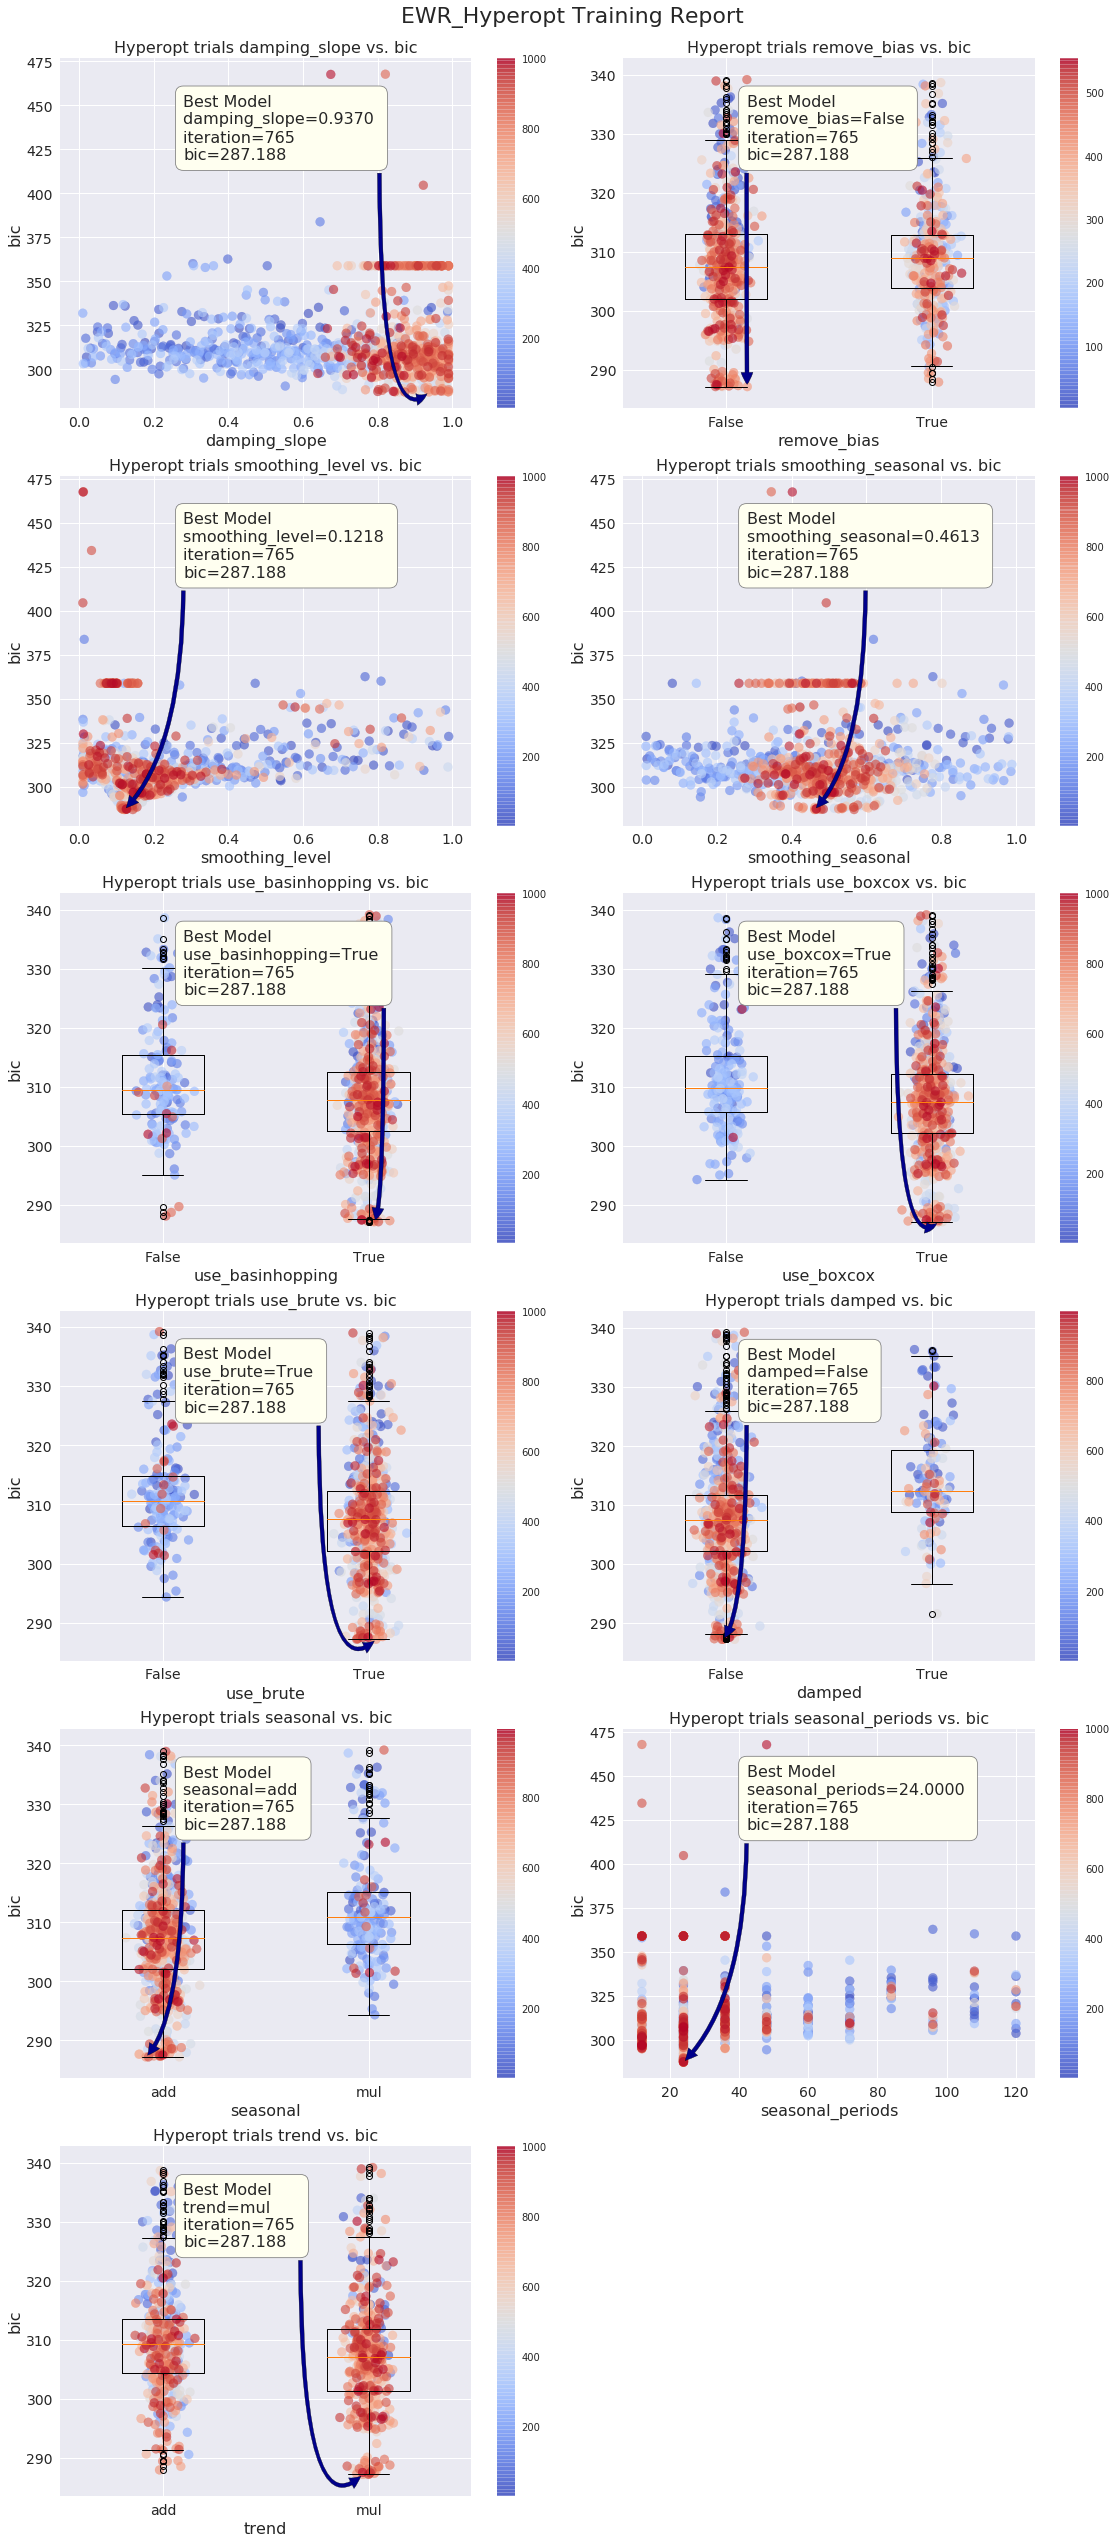

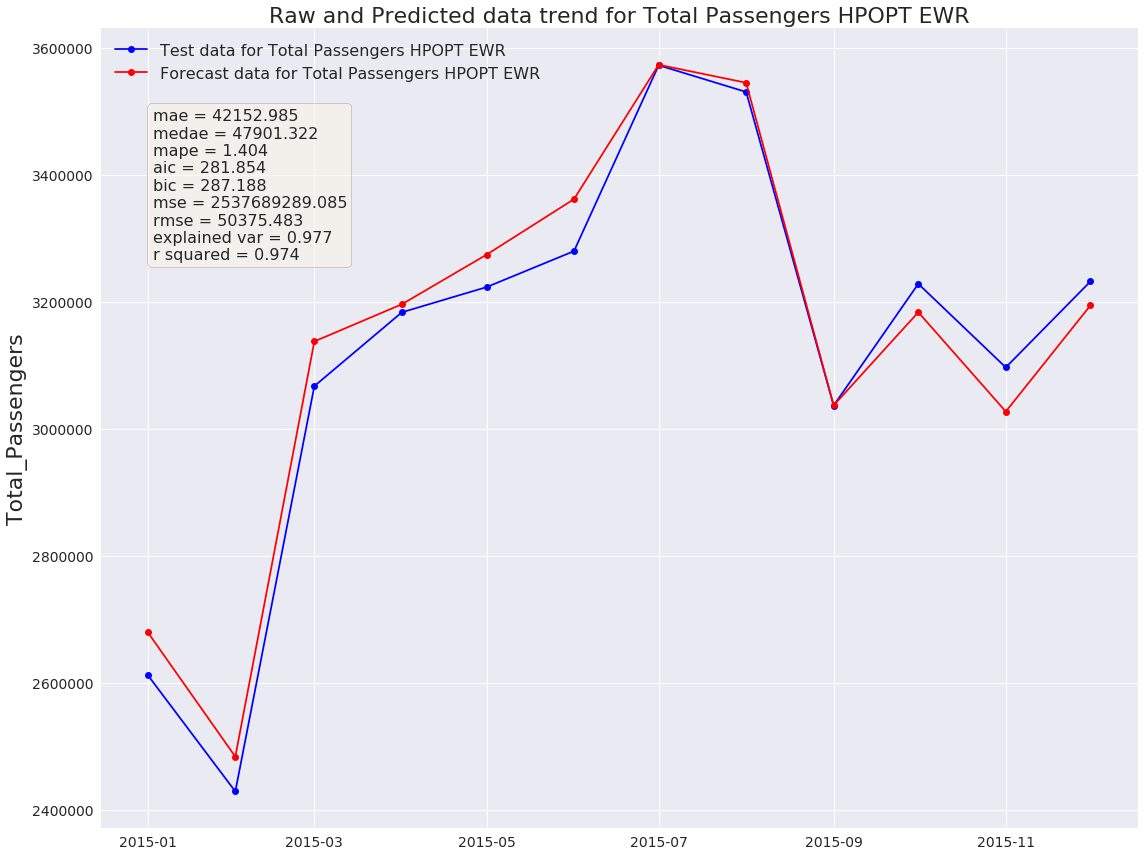

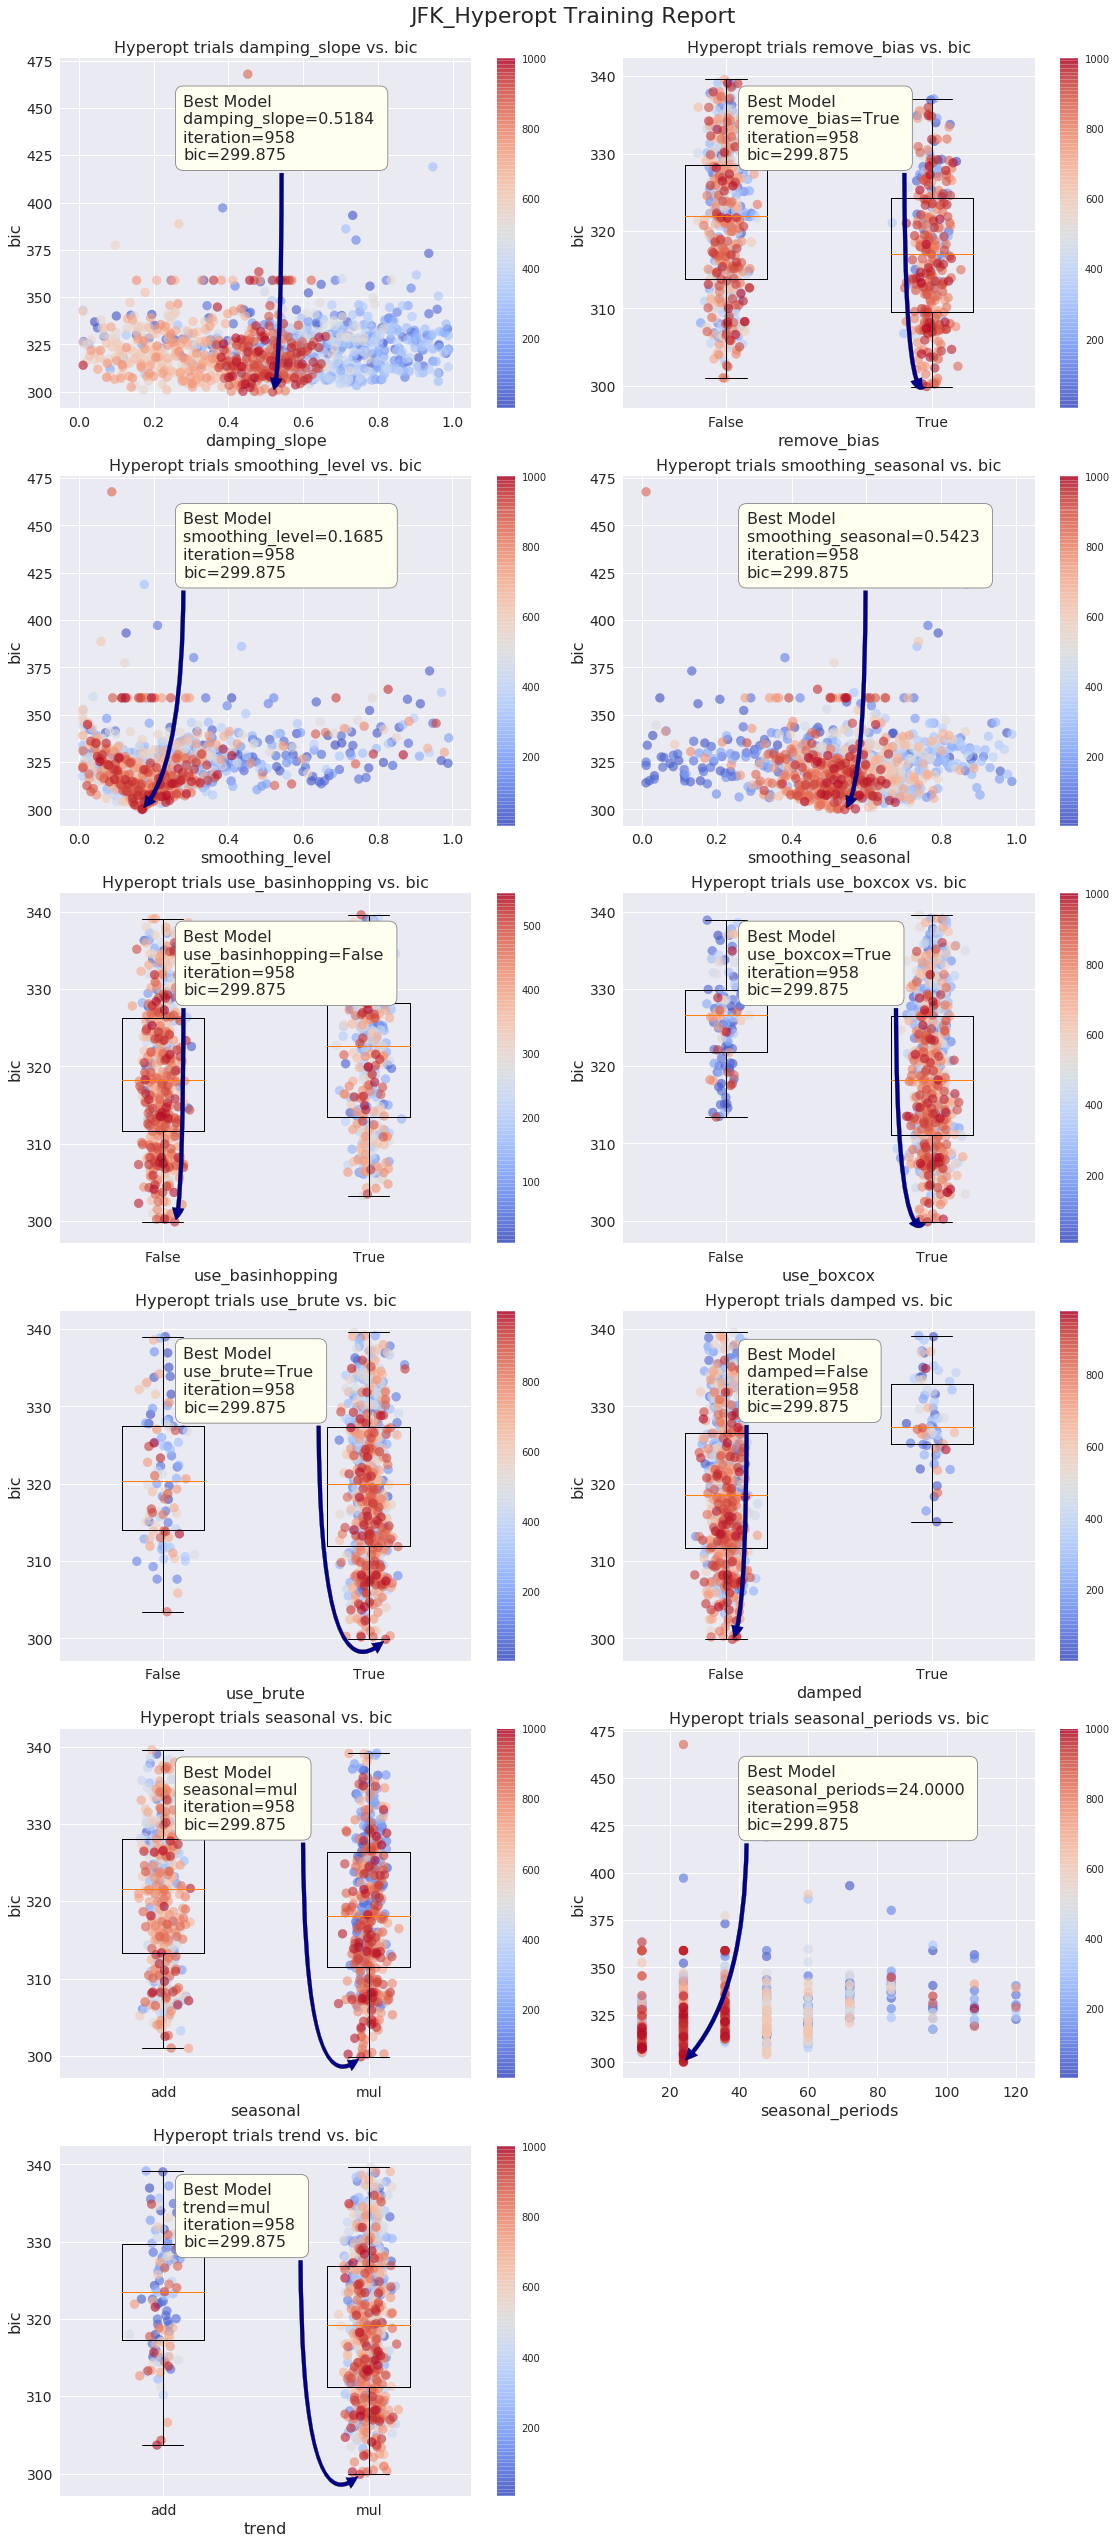

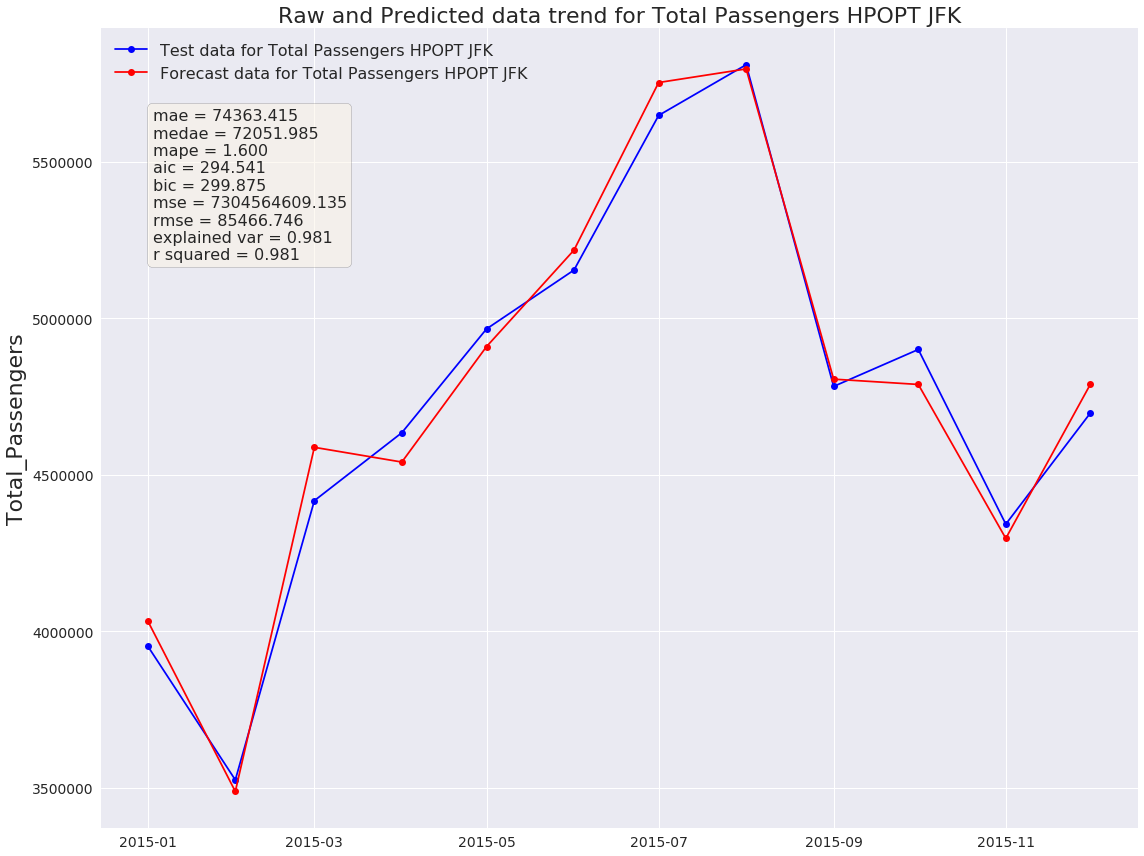

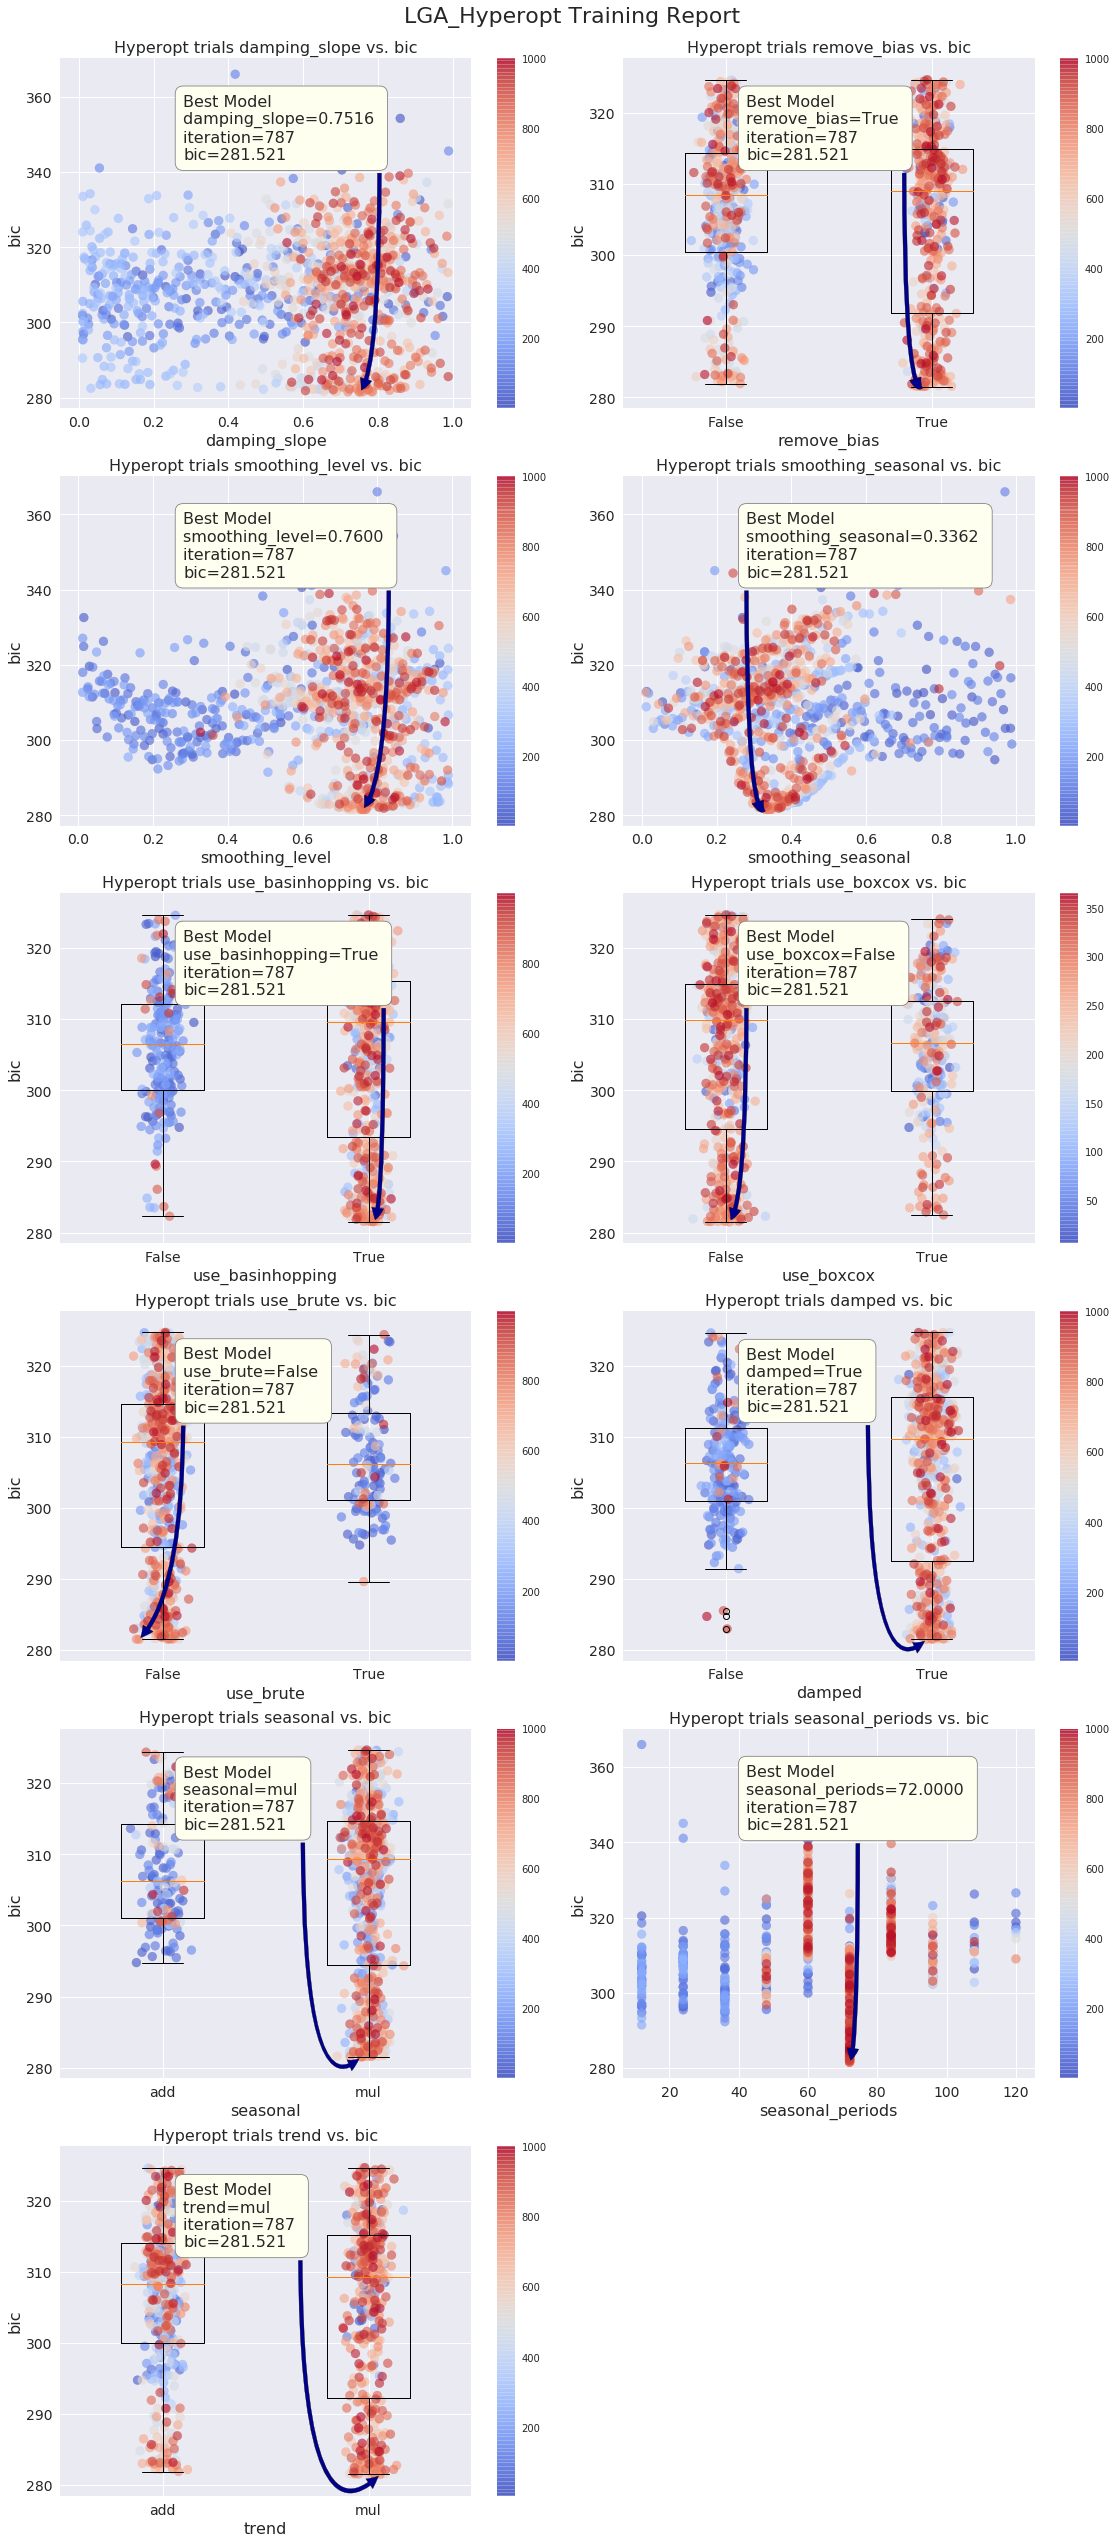

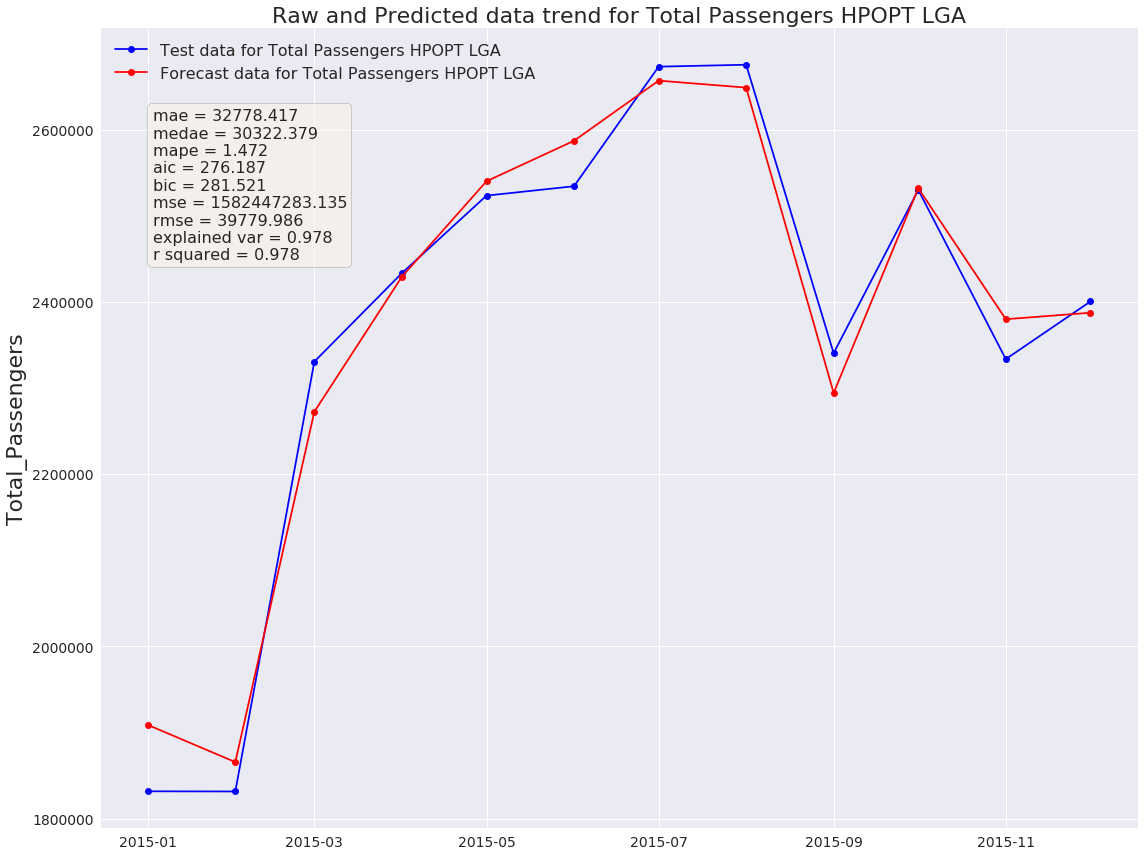

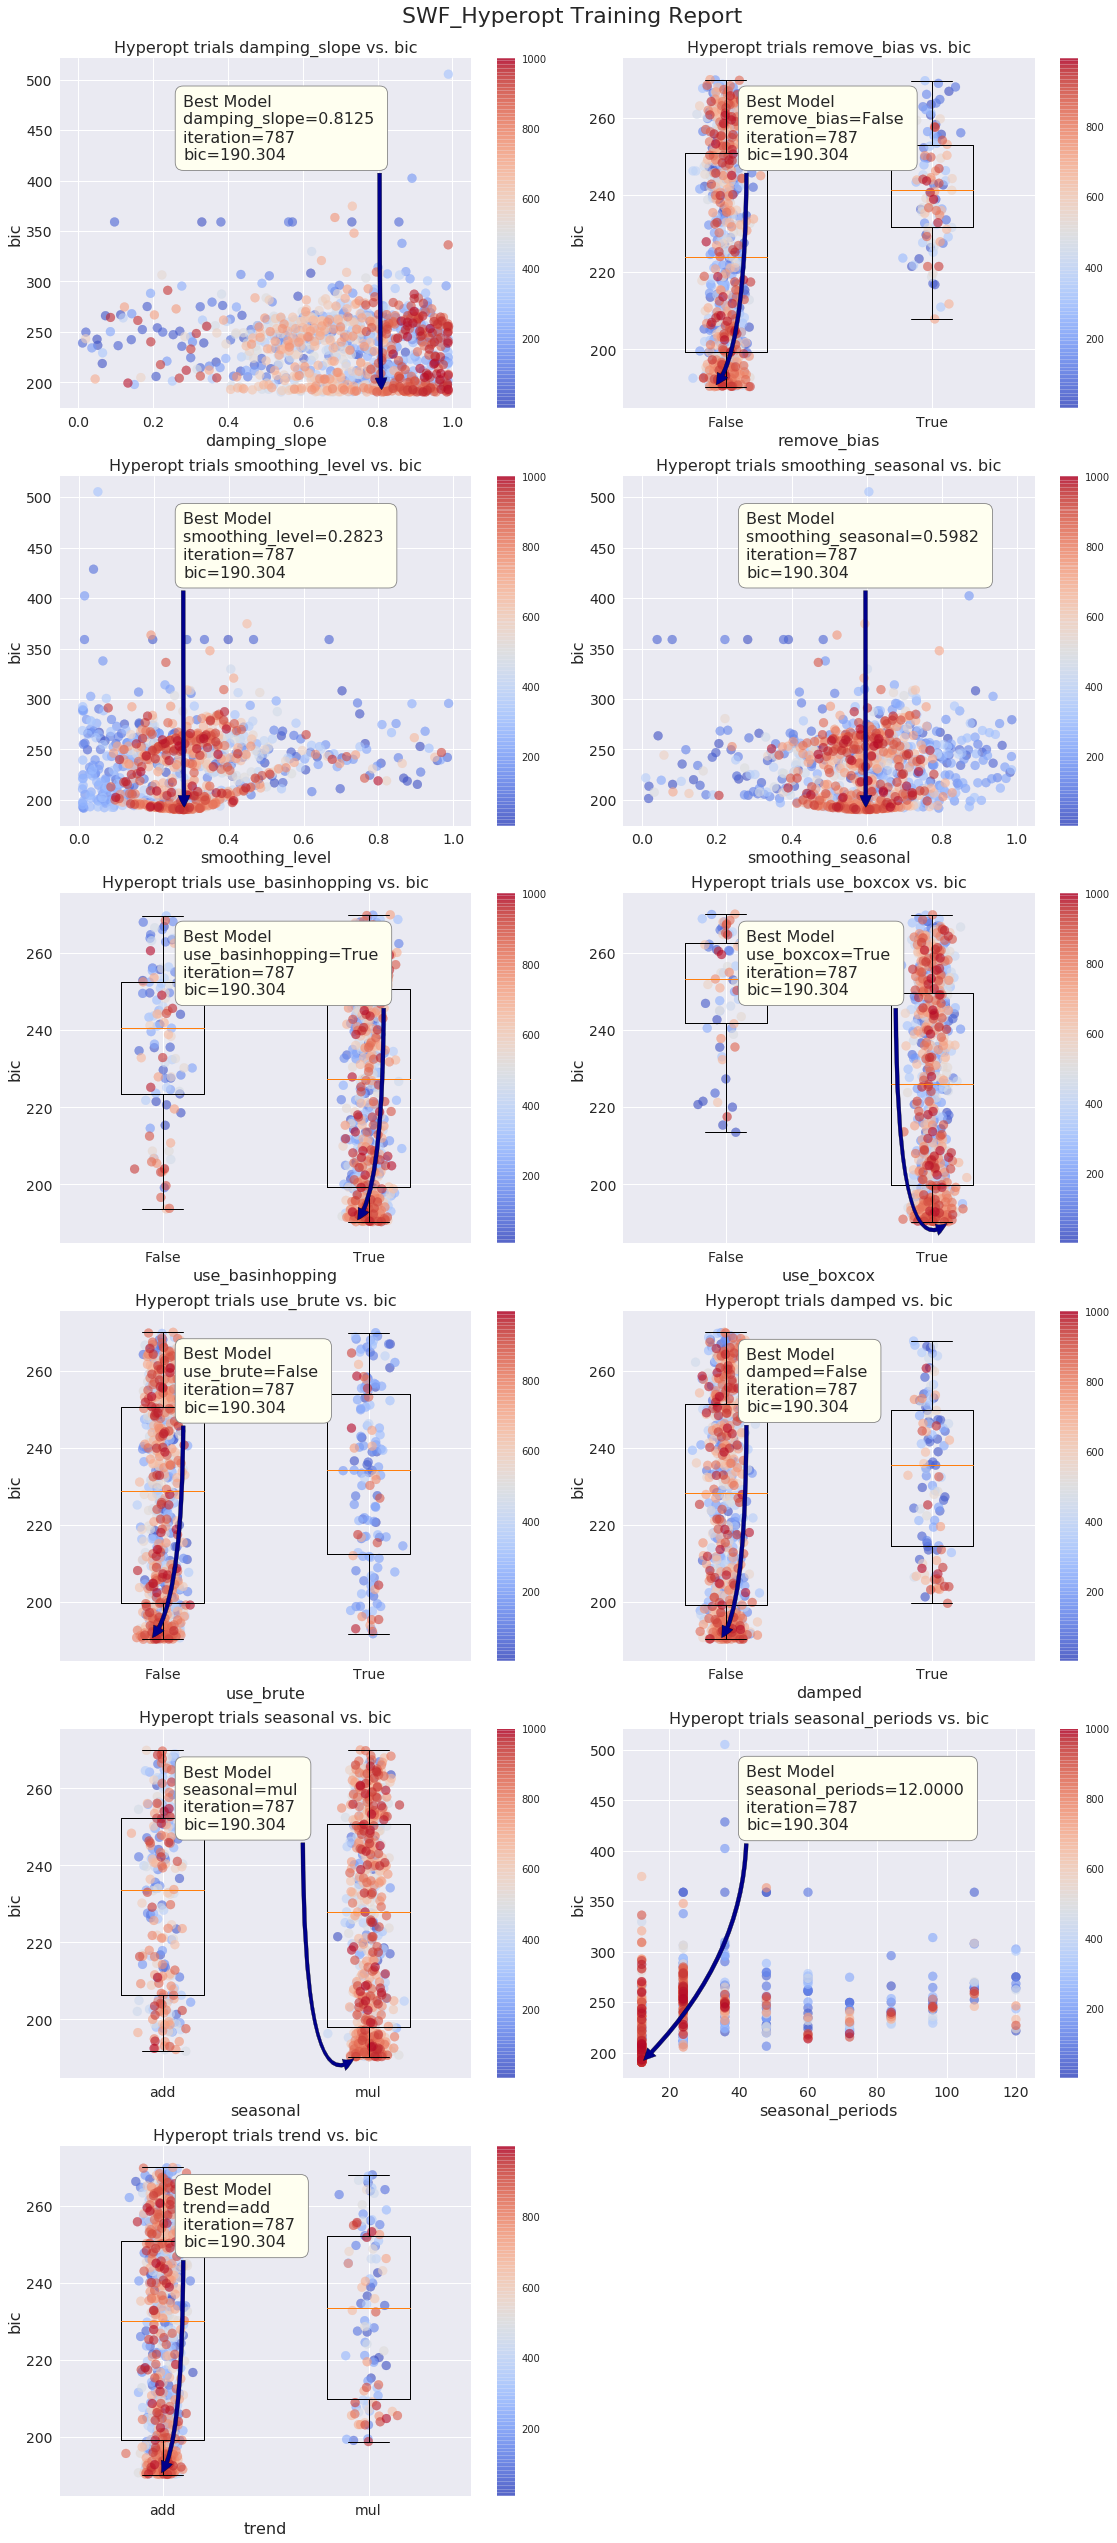

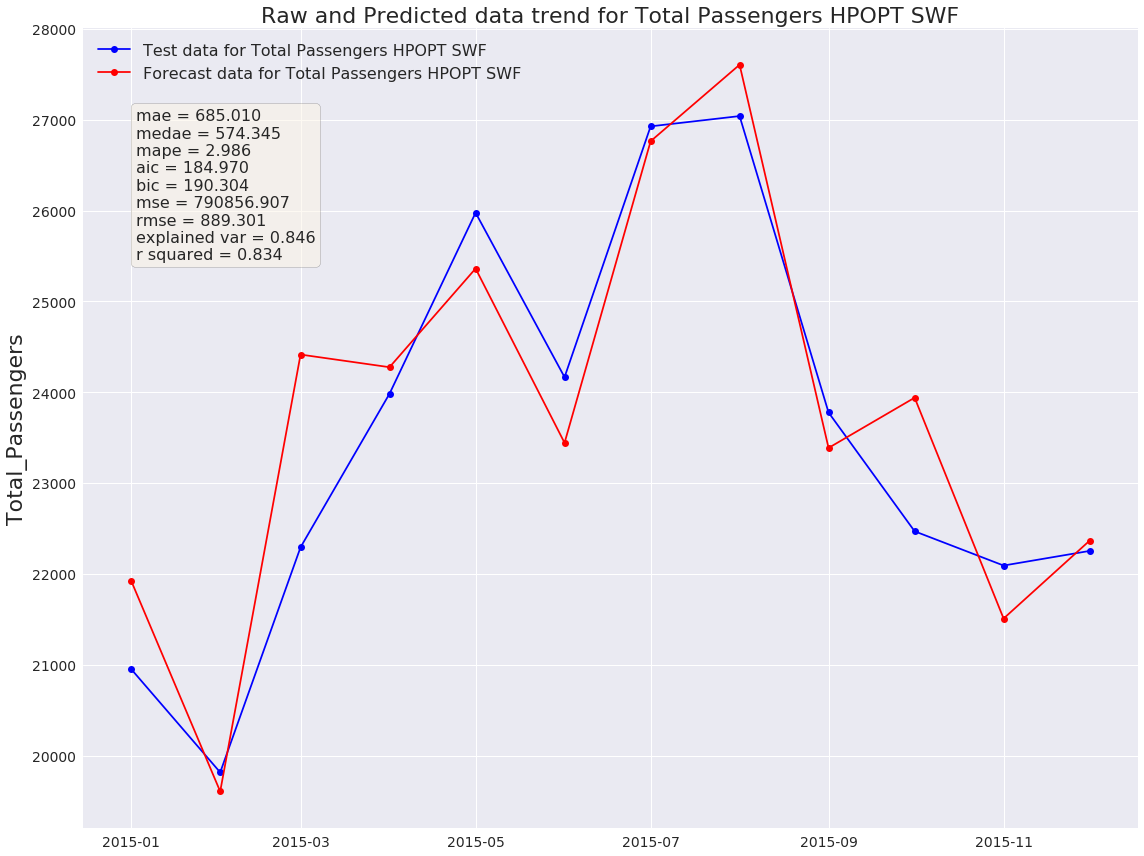

In [0]:

all_airports = run_all_models(**all_model_config)

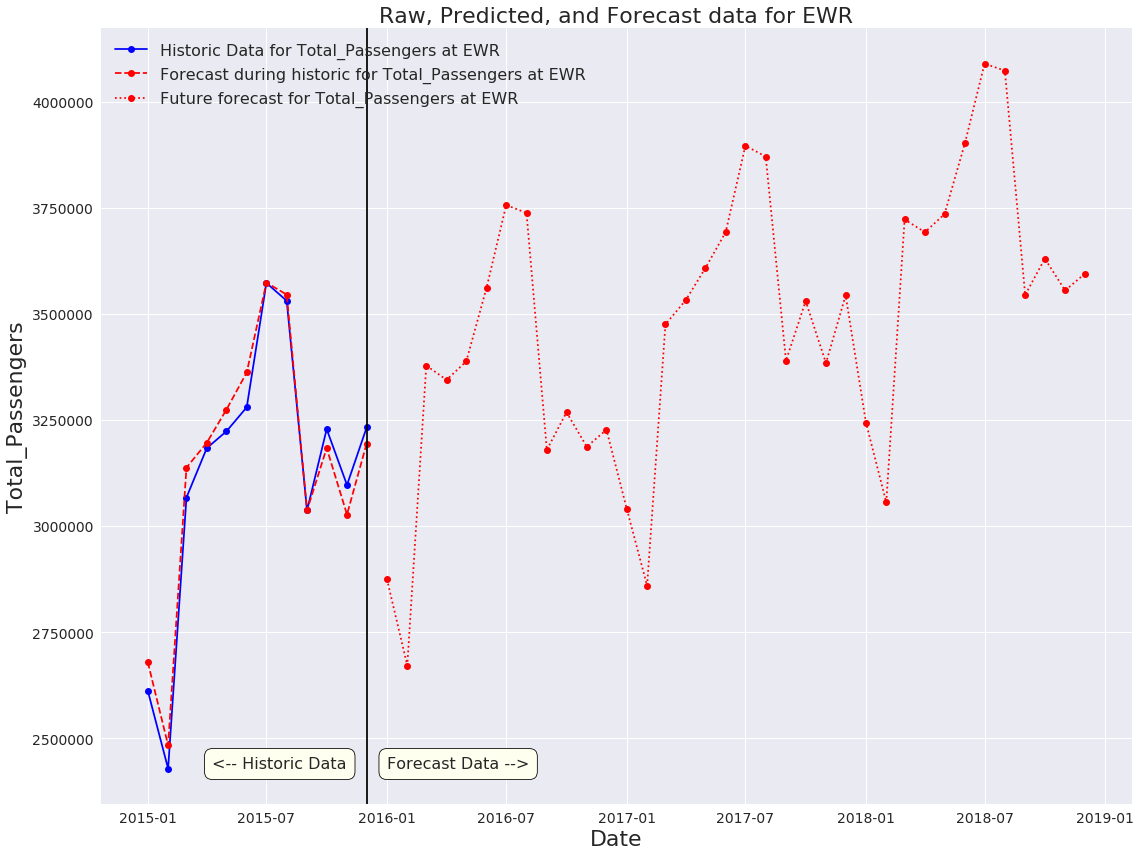

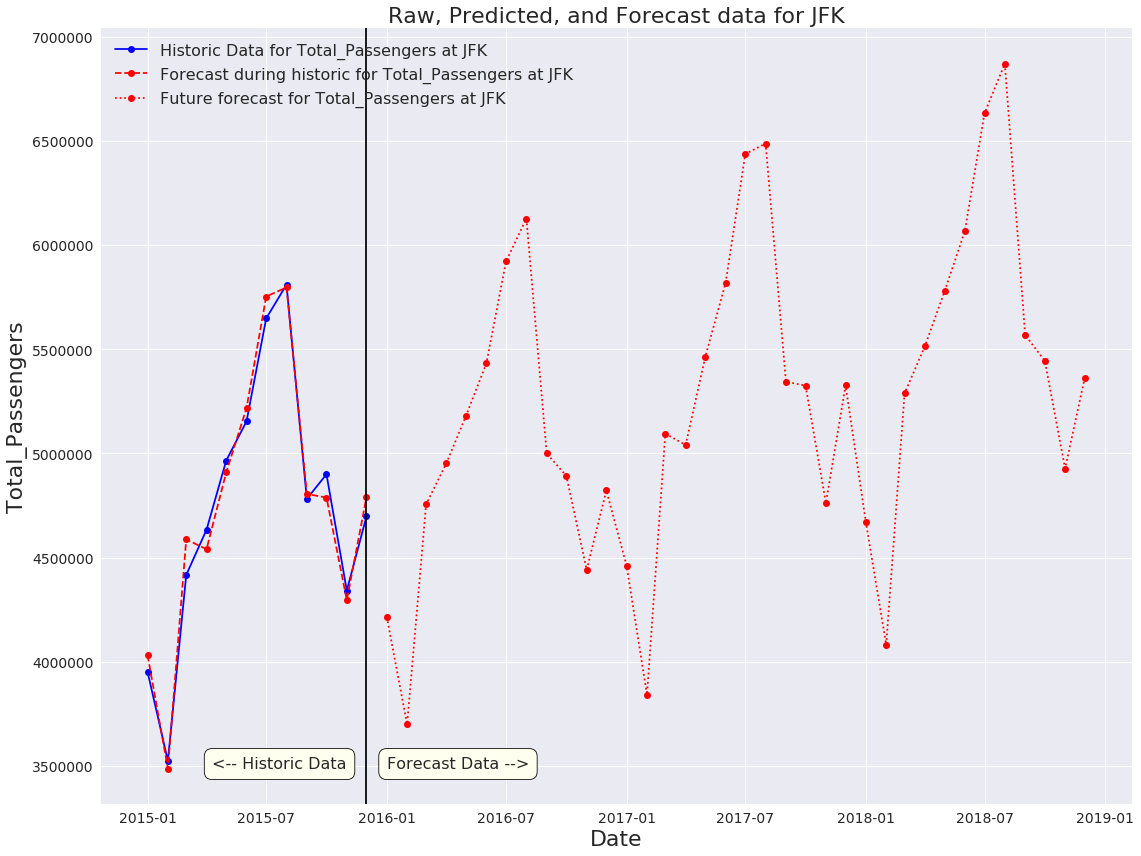

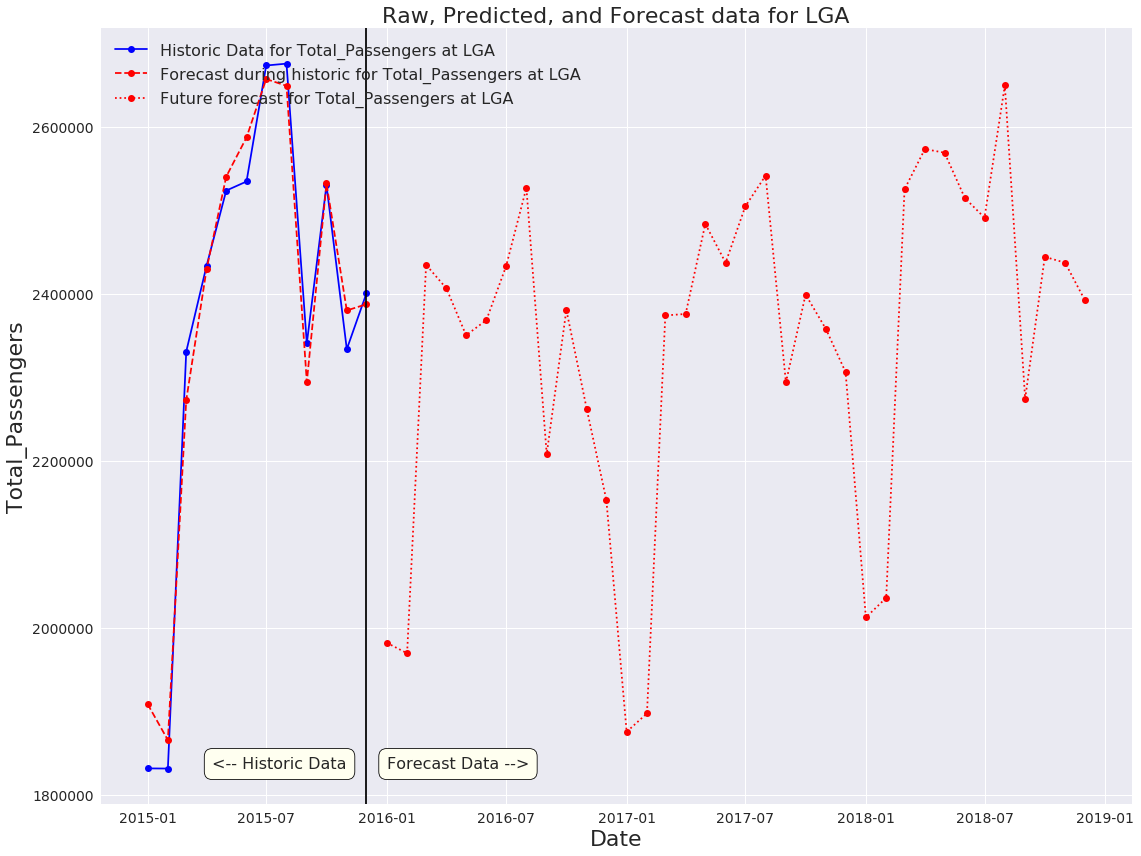

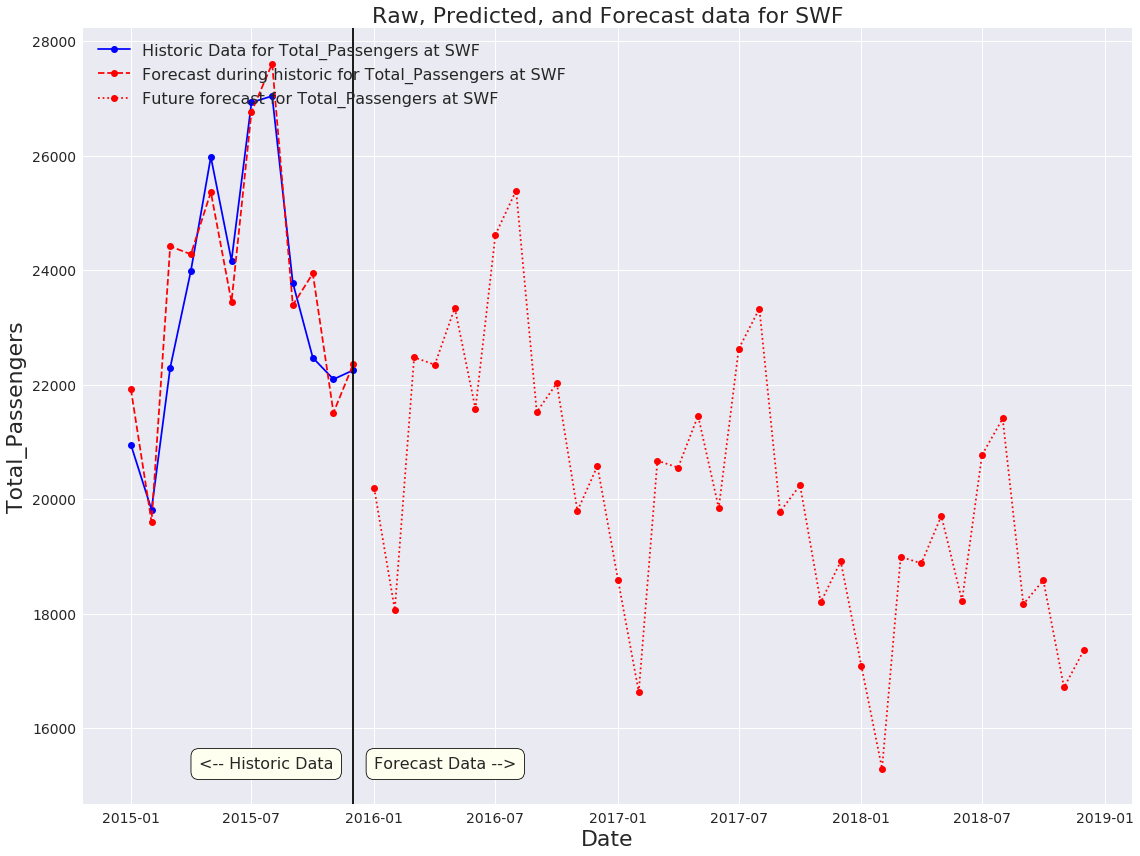

In [0]:
all_forecasts = build_forecast_dataset(all_airports, **all_model_config)
forecast_plots = generate_forecast_plots(all_forecasts, **plot_conf)

#### Alternative approach: distributing the airport modeling tasks to workers
In this section, we're looking at utilizing pandas_udf operations to parallelize the <b><i> model iterations</i></b> rather than the tuning. We'll be using the serial approach for hyperopt that we used in notebook CH7_2 (Trials() instead of SparkTrials() to keep track of the iterations and results), and instead of looping over the collection of airports, we will be submitting a 'stand-alone' modeling and tuning execution to each of the workers for each of the airports in our data set.

When compared to the implementation above in this notebook, the main changes to the modeling and minimization functions are in the movement of the mlflow context wrapper from the execution main loop that hyperopt is using and shifting to the creation of a new experiment for each iteration of each model. This is due to the fact that we're not using SparkTrials and we need to attach the iteration number of the Trials() object to the name of the experiment to ensure we have referenceable experiment names within the MLFlow Tracking server. <br>
Aside from that functional change, the other primary changes are: logging of the artifacts of forecasting loss plots for each iteration (which we did not do for the above SparkTrials implementation), explicitly setting the logging of parameters to individual keys (just to illustrate the alternative way of logging; not because of any need to do this), and the addition of a collision-proof naming convention to the experiments so that if the configuration doesn't get updated for a unique run number, there will not be an MLFlow expection thrown for attempting to mutate already logged parameters to an existing run.

In [0]:
def validate_data_counts_udf(data, split_count):
  """ Function for removing the airports from the data set that don't have enough data for forecasting accurately.
        This approach is significantly different from how we did this in the CH7_2 notebook, namely because we're 
        operating within Apache Spark DataFrames in order to get the list of qualifying airports for this modeling run.
     :param data: Spark DataFrame of the raw airport data loaded from Delta
     :param split_count: The number of elements in the test holdout series data set
     returns: a python list containing only the airports that meet the requirements of having enough data present for building an effective training and test set.
  """
    return list(data.groupBy(col('Airport_Code')).count().withColumn('check', when(((lit(split_count) / 0.2) < (col('count') * 0.8)), True).otherwise(False)).filter(col('check')).select('Airport_Code').toPandas()['Airport_Code'])

def exp_smoothing_raw_udf(train, test, selected_hp_values):
    """ Function for executing the model 'manually' (outside of hyperopt) without the embedded scoring.
    :param train: the training series data
    :param test: the test (validation) series data
    :param selected_hp_values: the instance of hyperparameter settings that hyperopt will provide upon selecting
        from the search space.
    
    Note: this is split out for two reasons: firstly, it's part of what hyperopt will need to call to build the
        model and run a forecast error metric calculation for tuning. Secondly, it is a useful manual-mode 
        validation of particular parameter selections (useful for debugging).
    """
    output = {}
    model = ExponentialSmoothing(train, 
                               trend=selected_hp_values['model']['trend'],
                               seasonal=selected_hp_values['model']['seasonal'],
                               seasonal_periods=selected_hp_values['model']['seasonal_periods'],
                               damped=selected_hp_values['model']['damped']
                              )
    model_fit = model.fit(smoothing_level=selected_hp_values['fit']['smoothing_level'],
                          smoothing_seasonal=selected_hp_values['fit']['smoothing_seasonal'],
                          damping_slope=selected_hp_values['fit']['damping_slope'],
                          use_brute=selected_hp_values['fit']['use_brute'],
                          use_boxcox=selected_hp_values['fit']['use_boxcox'],
                          use_basinhopping=selected_hp_values['fit']['use_basinhopping'],
                          remove_bias=selected_hp_values['fit']['remove_bias']
                         )
    forecast = model_fit.predict(train.index[-1], test.index[-1])
    output['model'] = model_fit
    output['forecast'] = forecast[1:]
    return output

def hwes_minimization_function_udf(selected_hp_values, train, test, loss_metric, airport, experiment_name, param_count, name, target_name, image_name, trial):
    """ Function for minimization. Accepts the selected hyperparameter values that hyperopt has chosen and 
            builds the model with those, predicts against test, scores, and returns the loss metric.
    :param selected_hp_values: a dictionary that hyperopt has chosen from the defined space.
    :param train: The training data series
    :param test: The test data series
    :param loss_metric: the loss metric that hyperopt is using for optimization.
    :param progress: reference to the progress tracker to display the progress of optimizing for this run.
    """
    model_results = exp_smoothing_raw_udf(train, test, selected_hp_values)
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_hwes(selected_hp_values))
    with mlflow.start_run(run_name='{}_{}_{}_{}'.format(airport, experiment_name,str(uuid.uuid4())[:8], len(trial.results))):
      mlflow.set_tag('airport', airport)
      mlflow.set_tag('parent_run', experiment_name)
      mlflow.log_param('id', mlflow.active_run().info.run_id)
      mlflow.log_param('damping_slope', selected_hp_values['fit']['damping_slope'])
      mlflow.log_param('remove_bias', selected_hp_values['fit']['remove_bias'])
      mlflow.log_param('smoothing_level', selected_hp_values['fit']['smoothing_level'])
      mlflow.log_param('smoothing_seasonal', selected_hp_values['fit']['smoothing_seasonal'])
      mlflow.log_param('use_basinhopping', selected_hp_values['fit']['use_basinhopping'])
      mlflow.log_param('use_boxcox', selected_hp_values['fit']['use_boxcox'])
      mlflow.log_param('use_brute', selected_hp_values['fit']['use_brute'])
      mlflow.log_param('damped', selected_hp_values['model']['damped'])
      mlflow.log_param('seasonal', selected_hp_values['model']['seasonal'])
      mlflow.log_param('seasonal_periods', selected_hp_values['model']['seasonal_periods'])
      mlflow.log_param('trend', selected_hp_values['model']['trend'])
      mlflow.log_metrics(errors)
      img = plot_predictions(test, 
                       model_results['forecast'], 
                       param_count,
                       name, 
                       target_name, 
                       image_name)
      mlflow.log_artifact(image_name)    
    return {'loss': errors[loss_metric], 'status': STATUS_OK}

### The big change...
Here is where the code needs to diverge quite a bit. We need to create a new function that supports executing a hyperopt trials run with a modified output (instead of returning a dictionary of all of the elements, we have to return just the forecast Pandas DataFrame)

In [0]:

def run_udf_tuning(train, test, **params):
    """ Function for executing the hyperopt auto-tuning for a single airport.
    :param train: the train series data
    :param test: the test (holdout) series data for loss metric calculation
    :param **params: dict, consisting of:
                 {'minimization_function': <the model training, evaluation, and loss estimation function>,
                  'tuning_space': <the hyperopt search space configuration>,
                  'forecast_algo': <the function for forecasting the data>,
                  'loss_metric': <the loss metric (e.g. 'aic', 'bic', 'mse', et al.)>,
                  'hpopt_algo': <the hyperopt optimization [recommended to choose either 
                                  tpe.suggest or random.suggest]>,
                  'iterations': <number of iterations for hyperopt to search through>,
                  'name': <the base name to be applied to visualizations as titles>,
                  'target_name': <The name of the 'target' column in the data (what we are trying to predict)>,
                  'image_name': <the base name of the images to be saved, which will get appended to the 
                                  airport name>,
                  'airport_name': <the name of the airport, for both labeling and filtering purposes>,
                  'future_forecast_periods': <the number of months to forecast in the future>,
                  'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
                  'hyperopt_title': <name for setting the hyperopt training report title>,
                  'hyperopt_image_name': <name for the saved images of the hyperopt training information which
                                    will get modified with the name of the airport>,
                  'verbose': <Boolean value that will control whether to print a bunch of information to stdout
                              while the optimization is running>,
                  'progress': <a progress monitor instantiation to give live notebook-formatted progress
                              of the optimization process>
                   }
    
    """
    param_count = extract_param_count_hwes(params['tuning_space'])
    output = {}
    trial_run = Trials()
    
    tuning = fmin(partial(params['minimization_function'], 
                          train=train, 
                          test=test,
                          loss_metric=params['loss_metric'],
                          airport=params['airport_name'],
                          experiment_name=params['experiment_name'],
                          param_count=param_count,
                          name=params['name'],
                          target_name=params['target_name'],
                          image_name=params['image_name'],
                          trial=trial_run
                         ), 
                  params['tuning_space'], 
                  algo=params['hpopt_algo'], 
                  max_evals=params['iterations'], 
                  trials=trial_run,
                  show_progressbar=False
                 )

    best_run = space_eval(params['tuning_space'], tuning)
    generated_model = params['forecast_algo'](train, test, best_run)
    forecasted_data = build_future_forecast(generated_model['model'],
                                                        params['airport_name'],
                                                        params['future_forecast_periods'],
                                                        params['train_split_cutoff_months'],
                                                        params['target_name']
                                                       )
    output['plot_data'] = plot_predictions(test, 
                                           generated_model['forecast'], 
                                           param_count,
                                           params['name'], 
                                           params['target_name'], 
                                           params['image_name'])
      
    return forecasted_data.reset_index().rename(columns={'index':'date'})

### The pandas_udf
Here we're building the execution logic that will run on the workers for each airport's data. Since there is no means of passing a configuration in to the udf (it can only accept a Pandas DataFrame as input), we are setting the configuration for search space and the 'job configs' within the udf.
In a production build of this, all of these elements would be defined in a configuration class that the udf would serialize and read from, rather than putting them directly within the udf code. It is listed out here to aid in legibility for what is going on in this function.

In [0]:
output_schema = StructType([
  StructField('date', DateType()),
  StructField('Total_Passengers_pred', IntegerType()),
  StructField('Airport', StringType()),
  StructField('is_future', BooleanType())
])

@pandas_udf(output_schema, PandasUDFType.GROUPED_MAP)
def forecast_airports(airport_df):
  """ A pandas_udf function Grouped Map type that will run the model optimization and forecasting of 
        the most optimal hyperparameters found for the model
      :param airport_df: a Pandas DataFrame serialized through Apache Arrow that comes from the grouped aggregation of the Spark DataFrame.
      return: A Pandas DataFrame with the forecast data
  """
  
  airport = airport_df['Airport_Code'][0]
  hpopt_space = {
    'model': {
          'trend': hp.choice('trend', ['add', 'mul']),
          'seasonal': hp.choice('seasonal', ['add', 'mul']),
          'seasonal_periods': hp.quniform('seasonal_periods', 12, 120, 12),
          'damped': hp.choice('damped', [True, False])
    },
    'fit': {
          'smoothing_level': hp.uniform('smoothing_level', 0.01, 0.99),
          'smoothing_seasonal': hp.uniform('smoothing_seasonal', 0.01, 0.99),
          'damping_slope': hp.uniform('damping_slope', 0.01, 0.99),
          'use_brute': hp.choice('use_brute', [True, False]),
          'use_boxcox': hp.choice('use_boxcox', [True, False]),
          'use_basinhopping': hp.choice('use_basinhopping', [True, False]),
          'remove_bias': hp.choice('remove_bias', [True, False])
    }
  }

  run_config = {'minimization_function': hwes_minimization_function_udf,
                  'tuning_space': hpopt_space,
                  'forecast_algo': exp_smoothing_raw,
                  'loss_metric': 'bic',
                  'hpopt_algo': tpe.suggest,
                  'iterations': 600,
                  'experiment_name': RUN_NAME,
                  'name': '{} {}'.format('Total Passengers HPOPT', airport),
                  'target_name': 'Total_Passengers',
                  'image_name': '{}_{}.png'.format('total_passengers_validation', airport),
                  'airport_name': airport,
                  'future_forecast_periods': 36,
                  'train_split_cutoff_months': 12,
                  'hyperopt_title': '{}_Hyperopt Training Report'.format(airport),
                  'hyperopt_image_name': '{}_{}.png'.format('total_passengers_hpopt', airport),
                  'verbose': True
            }
  

  airport_data = airport_df.copy(deep=True)
  airport_data['date'] = pd.to_datetime(airport_data['date'])
  airport_data.set_index('date', inplace=True)
  airport_data.index = pd.DatetimeIndex(airport_data.index.values, freq=airport_data.index.inferred_freq)
  asc = airport_data.sort_index()
  asc = apply_index_freq(asc, 'MS')
 
  train, test = generate_splits_by_months(asc, run_config['train_split_cutoff_months'])
  
  tuning = run_udf_tuning(train['Total_Passengers'], test['Total_Passengers'], **run_config)
  
  return tuning



### Execution of the distributed per-airport modeling with pandas_udf
In order to achieve the distributed modeling using this paradigm (which scales horizontally; in order to make the entire process go faster, just simply add more worker nodes), all we need do is group the Spark DataFrame by the airport key then apply the pandas_udf. Each airport will be submitted to available workers to process in parallel.
> <b>NOTE:</b> since this example is only modeling 4 airports worth of data, the runtime isn't much better than the above solution. But, for the simulated actual project that this is aiming to address, this approach will scale MUCH BETTER than any other (aside from parallelizing the training further by using threadpools on the workers by grouping by collections of airports in each pandas_udf and spinning up concurrent processing on the workers for each of those airports).

In [0]:
RUN_NAME = 'PANDAS_UDF_RUN_1'
raw_data = spark.table(delta_full_nm)
filtered_data = raw_data.where(col('Airport_Code').isin(validate_data_counts_udf(raw_data, 12))).repartition('Airport_Code')
grouped_apply = filtered_data.groupBy('Airport_Code').apply(forecast_airports)
display(grouped_apply)

date Total_Passengers_pred Airport is_future 2015-01-01 1905680 LGA false 2015-02-01 1865278 LGA false 2015-03-01 2273815 LGA false 2015-04-01 2429561 LGA false 2015-05-01 2542933 LGA false 2015-06-01 2593381 LGA false 2015-07-01 2666434 LGA false 2015-08-01 2649447 LGA false 2015-09-01 2298688 LGA false 2015-10-01 2540804 LGA false 2015-11-01 2390231 LGA false 2015-12-01 2399839 LGA false 2016-01-01 1991927 LGA true 2016-02-01 1976227 LGA true 2016-03-01 2457574 LGA true 2016-04-01 2424109 LGA true 2016-05-01 2365524 LGA true 2016-06-01 2379697 LGA true 2016-07-01 2449478 LGA true 2016-08-01 2545260 LGA true 2016-09-01 2222342 LGA true 2016-10-01 2395553 LGA true 2016-11-01 2278111 LGA true 2016-12-01 2166905 LGA true 2017-01-01 1881964 LGA true 2017-02-01 1904570 LGA true 2017-03-01 2394093 LGA true 2017-04-01 2386556 LGA true 2017-05-01 2494813 LGA true 2017-06-01 2443270 LGA true 2017-07-01 2511094 LGA true 2017-08-01 2551177 LGA true 2017-09-01 2309442 LGA true 2017-10-01 2408161 LGA true 2017-11-01 2367355 LGA true 2017-12-01 2314798 LGA true 2018-01-01 2017398 LGA true 2018-02-01 2041498 LGA true 2018-03-01 2538515 LGA true 2018-04-01 2589903 LGA true 2018-05-01 2579797 LGA true 2018-06-01 2522195 LGA true 2018-07-01 2501048 LGA true 2018-08-01 2662845 LGA true 2018-09-01 2281881 LGA true 2018-10-01 2455266 LGA true 2018-11-01 2449750 LGA true 2018-12-01 2411473 LGA true 2015-01-01 2637768 EWR false 2015-02-01 2373124 EWR false 2015-03-01 3114068 EWR false 2015-04-01 3156181 EWR false 2015-05-01 3265042 EWR false 2015-06-01 3365495 EWR false 2015-07-01 3596411 EWR false 2015-08-01 3574351 EWR false 2015-09-01 3010744 EWR false 2015-10-01 3183216 EWR false 2015-11-01 2980368 EWR false 2015-12-01 3220623 EWR false 2016-01-01 2811210 EWR true 2016-02-01 2537906 EWR true 2016-03-01 3438508 EWR true 2016-04-01 3390437 EWR true 2016-05-01 3464482 EWR true 2016-06-01 3707326 EWR true 2016-07-01 3967767 EWR true 2016-08-01 3938892 EWR true 2016-09-01 3249005 EWR true 2016-10-01 3331815 EWR true 2016-11-01 3221271 EWR true 2016-12-01 3246006 EWR true 2017-01-01 2992776 EWR true 2017-02-01 2692648 EWR true 2017-03-01 3532940 EWR true 2017-04-01 3580700 EWR true 2017-05-01 3704157 EWR true 2017-06-01 3818079 EWR true 2017-07-01 4079956 EWR true 2017-08-01 4054938 EWR true 2017-09-01 3415761 EWR true 2017-10-01 3611359 EWR true 2017-11-01 3381313 EWR true 2017-12-01 3653781 EWR true 2018-01-01 3189474 EWR true 2018-02-01 2879525 EWR true 2018-03-01 3900881 EWR true 2018-04-01 3846364 EWR true 2018-05-01 3930338 EWR true 2018-06-01 4205743 EWR true 2018-07-01 4501104 EWR true 2018-08-01 4468358 EWR true 2018-09-01 3685970 EWR true 2018-10-01 3779883 EWR true 2018-11-01 3654517 EWR true 2018-12-01 3682568 EWR true 2015-01-01 21908 SWF false 2015-02-01 19175 SWF false 2015-03-01 24407 SWF false 2015-04-01 24076 SWF false 2015-05-01 25316 SWF false 2015-06-01 23128 SWF false 2015-07-01 26715 SWF false 2015-08-01 27497 SWF false 2015-09-01 22884 SWF false 2015-10-01 23841 SWF false 2015-11-01 21292 SWF false 2015-12-01 22425 SWF false 2016-01-01 19775 SWF true 2016-02-01 17039 SWF true 2016-03-01 22269 SWF true 2016-04-01 21937 SWF true 2016-05-01 23173 SWF true 2016-06-01 20984 SWF true 2016-07-01 24568 SWF true 2016-08-01 25348 SWF true 2016-09-01 20733 SWF true 2016-10-01 21688 SWF true 2016-11-01 19137 SWF true 2016-12-01 20268 SWF true 2017-01-01 17615 SWF true 2017-02-01 14877 SWF true 2017-03-01 20105 SWF true 2017-04-01 19770 SWF true 2017-05-01 21005 SWF true 2017-06-01 18813 SWF true 2017-07-01 22395 SWF true 2017-08-01 23173 SWF true 2017-09-01 18556 SWF true 2017-10-01 19508 SWF true 2017-11-01 16955 SWF true 2017-12-01 18084 SWF true 2018-01-01 15429 SWF true 2018-02-01 12689 SWF true 2018-03-01 17914 SWF true 2018-04-01 17577 SWF true 2018-05-01 18810 SWF true 2018-06-01 16616 SWF true 2018-07-01 20195 SWF true 2018-08-01 20971 SWF true 2018-09-01 16351 SWF true 2018-10-01 17301 SWF true 2018-11-01 14746 SWF true 2018-12-0